In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
#train model
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
# Load the Excel file and check the sheet names
excel_path = "Subject1.xlsx"
xls = pd.ExcelFile(excel_path)
sheet_names = xls.sheet_names

sheet_names

['CGM', 'Bolus']

In [11]:
df_cgm = pd.read_excel(excel_path, sheet_name='CGM')
print(df_cgm.columns)


Index(['date', 'mg/dl'], dtype='object')


In [17]:
import pandas as pd

def load_and_prepare_data(excel_path: str):
    """Load CGM and Bolus data from Excel and clean them."""

    # Load sheets
    df_cgm = pd.read_excel(excel_path, sheet_name="CGM")
    df_bolus = pd.read_excel(excel_path, sheet_name="Bolus", parse_dates=["date"])

    # Clean CGM data
    df_cgm = (
        df_cgm.rename(columns={"mg/dl": "glucose"})
              .assign(glucose=lambda d: pd.to_numeric(d["glucose"], errors="coerce"),
                      date=lambda d: pd.to_datetime(d["date"], errors="coerce"))
              .sort_values("date")
    )

    # Interpolate missing dates (if at least 2 valid dates exist)
    if df_cgm["date"].notnull().sum() >= 2 and df_cgm["date"].isnull().any():
        df_cgm["date"] = (
            df_cgm["date"].astype("int64")
            .interpolate()
            .astype("int64")
            .astype("datetime64[ns]")
        )

    # Clean Bolus data
    df_bolus = df_bolus.dropna(subset=["date"]).sort_values("date")

    # Quick summary
    print("✅ CGM: {} rows | Null dates: {} | Range: {} → {}".format(
        len(df_cgm),
        df_cgm["date"].isnull().sum(),
        df_cgm["date"].min(),
        df_cgm["date"].max()
    ))

    print("✅ Bolus: {} rows | Range: {} → {}".format(
        len(df_bolus),
        df_bolus["date"].min(),
        df_bolus["date"].max()
    ))

    return df_cgm, df_bolus
df_cgm, df_bolus = load_and_prepare_data(excel_path)

✅ CGM: 462400 rows | Null dates: 0 | Range: 2015-12-01 21:01:07.925000 → 2021-11-18 23:56:52
✅ Bolus: 1112 rows | Range: 2021-07-18 16:48:04 → 2021-11-18 22:17:36


In [19]:
# Align CGM with Bolus date range
start_date, end_date = df_bolus["date"].min(), df_bolus["date"].max()

df_cgm_filtered = df_cgm.query("@start_date <= date <= @end_date")

print("✅ CGM aligned to Bolus:")
print("Rows:", df_cgm_filtered.shape[0])
print("Range:", df_cgm_filtered["date"].min(), "→", df_cgm_filtered["date"].max())


✅ CGM aligned to Bolus:
Rows: 52179
Range: 2021-07-18 16:50:03 → 2021-11-18 22:16:51


In [21]:
print(df_bolus['date'].min(), df_bolus['date'].max())
print(df_cgm_filtered['date'].min(), df_cgm_filtered['date'].max())

2021-07-18 16:48:04 2021-11-18 22:17:36
2021-07-18 16:50:03 2021-11-18 22:16:51


### column that acknowleges insulin


In [76]:


# -------------------------------
# Helpers
# -------------------------------
def estimate_meal_size(carb: float) -> str:
    if pd.isna(carb) or carb == 0:
        return "none"
    elif carb <= 30:
        return "small"
    elif carb <= 60:
        return "medium"
    return "large"

def likely_active(hour: int) -> int:
    return int(6 <= hour <= 9 or 16 <= hour <= 19)

def add_iob_cib(df, insulin_duration=4, carb_coverage_factor=12, clip_cib=50):
    """Compute Insulin on Board (IOB) and Carbs in Body (CIB)."""
    df = df.copy()
    iob = np.zeros(len(df))

    for i in range(1, len(df)):
        delta_t = (df["date"].iloc[i] - df["date"].iloc[i-1]).total_seconds() / 3600
        decay = np.exp(-delta_t / insulin_duration) if delta_t > 0 else 1
        iob[i] = iob[i-1] * decay + df["normal"].iloc[i]

    df["IOB"] = iob
    df["CIB"] = df["carbInput"] - (df["normal"] * carb_coverage_factor)
    if clip_cib:
        df["CIB"] = df["CIB"].clip(-clip_cib, clip_cib)

    df["IOB_decay"] = df["IOB"].ewm(halflife=30).mean()
    df["CIB_trend"] = df["CIB"].diff().fillna(0)
    return df

def engineer_iob_cib_features(df, iob_col="IOB", cib_col="CIB", span=12):
    """
    Adds advanced IOB & CIB features for LSTM.
    span = smoothing factor (~span*5min = half-life).
    """
    df = df.copy()

    # 1. Event flags
    df["had_insulin"] = (df[iob_col] > 0).astype(int)
    df["had_carb"] = (df[cib_col] != 0).astype(int)

    # 2. Smoothed features
    df["IOB_smooth"] = df[iob_col].ewm(span=span, adjust=False).mean()
    df["CIB_smooth"] = df[cib_col].ewm(span=span, adjust=False).mean()

    # 3. Interaction
    df["net_effect"] = df[iob_col] - df[cib_col]

    # 4. Buckets
    df["IOB_level"] = pd.cut(
        df[iob_col],
        bins=[-0.1, 0, 10, 40, np.inf],
        labels=["none", "low", "medium", "high"]
    )
    df["CIB_status"] = pd.cut(
        df[cib_col],
        bins=[-np.inf, -1, 1, np.inf],
        labels=["carb_dominant", "balanced", "insulin_dominant"]
    )

    # 5. One-hot encoding for categorical features
    df = pd.get_dummies(df, columns=["IOB_level", "CIB_status"], prefix=["IOB", "CIB"])

    return df

def clean_for_model(df, sparse_thresh=0.95):
    """Prepare final matrix for ML models."""
    df = df.copy()

    # Drop intermediate timestamps
    df.drop(columns=["last_meal_time", "last_insulin_time"], inplace=True, errors="ignore")

    # Convert bool → int
    bool_cols = df.select_dtypes("bool").columns
    df[bool_cols] = df[bool_cols].astype(int)

    # Drop very sparse cols
    sparse_cols = df.columns[df.isnull().mean() > sparse_thresh]
    df.drop(columns=sparse_cols, inplace=True)

    # Fill remaining NaNs
    df = df.fillna(0)

    return df





In [78]:
# -------------------------------
# Main Feature Engineering Pipeline
# -------------------------------
def engineer_features(df_cgm, df_bolus,
                      insulin_duration=4, carb_coverage_factor=12, clip_cib=50,
                      iob_span=12):
    df = df_cgm.copy()

    # --- 0. Clean inputs ---
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df_bolus["date"] = pd.to_datetime(df_bolus["date"], errors="coerce")
    df.dropna(subset=["date"], inplace=True)
    df_bolus.dropna(subset=["date"], inplace=True)

    # --- 1. Glucose dynamics ---
    df["glucose_change"] = df["glucose"].diff()
    df["glucose_t-1"] = df["glucose"].shift(1)

    # --- 2. Time-based features ---
    df["hour"] = df["date"].dt.hour
    df["minute"] = df["date"].dt.minute
    df["day_of_week"] = df["date"].dt.dayofweek

    # Cyclical encoding
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["minute_sin"] = np.sin(2 * np.pi * df["minute"] / 60)
    df["minute_cos"] = np.cos(2 * np.pi * df["minute"] / 60)
    df["day_sin"] = np.sin(2 * np.pi * df["day_of_week"] / 7)
    df["day_cos"] = np.cos(2 * np.pi * df["day_of_week"] / 7)

    df["weekend"] = df["day_of_week"].isin([5, 6]).astype(int)
    df["night"] = ((df["hour"] >= 22) | (df["hour"] < 6)).astype(int)

    # --- 3. Prediction target ---
    df["target"] = df["glucose"].shift(-6)  # 30min ahead

    # --- 4. Merge Bolus ---
    df = pd.merge_asof(
        df.sort_values("date"),
        df_bolus.sort_values("date"),
        on="date",
        direction="nearest",
        tolerance=pd.Timedelta("5min")
    )

    # --- 5. Fill NaNs ---
    df["normal"] = df["normal"].fillna(0)
    df["carbInput"] = df["carbInput"].fillna(0)
    df["bgInput"] = df["bgInput"].fillna(df["glucose"])
    df["targetBloodGlucose"] = df["targetBloodGlucose"].fillna(110)

    # --- 6. Meal features ---
    df["meal_size"] = df["carbInput"].apply(estimate_meal_size)
    df = pd.get_dummies(df, columns=["meal_size"], prefix="meal")

    # --- 7. Time since last meal/insulin ---
    df["last_meal_time"] = df["date"].where(df["carbInput"] > 0)
    df["last_insulin_time"] = df["date"].where(df["normal"] > 0)

    df["time_since_meal"] = (
        (df["date"] - df["last_meal_time"].ffill()).dt.total_seconds() / 3600
    )
    df["time_since_insulin"] = (
        (df["date"] - df["last_insulin_time"].ffill()).dt.total_seconds() / 3600
    )

    # --- 8. Gaps & activity ---
    df["glucose_gap"] = df["bgInput"] - df["targetBloodGlucose"]
    df["bg_drop"] = df["glucose_t-1"] - df["glucose"]

    df["recent_insulin"] = (df["time_since_insulin"] < 2).astype(int)
    df["possible_activity"] = ((df["bg_drop"] > 10) & (df["recent_insulin"] == 0)).astype(int)

    df["likely_active"] = df["hour"].apply(likely_active)
    df["activity_score"] = 0.5 * df["possible_activity"] + 0.5 * df["likely_active"]

    # --- 9. IOB & CIB ---
    df = add_iob_cib(df, insulin_duration, carb_coverage_factor, clip_cib)

    # --- 10. Advanced IOB/CIB features ---
    df = engineer_iob_cib_features(df, iob_col="IOB", cib_col="CIB", span=iob_span)

    # --- 11. Final cleaning ---
    df.dropna(subset=["glucose", "target"], inplace=True)
    df = clean_for_model(df)

    return df

df_features = engineer_features(df_cgm_filtered, df_bolus,
                      insulin_duration=4, carb_coverage_factor=12, clip_cib=50,
                      iob_span=12)

In [80]:
df_features.head()

,date,glucose,glucose_change,glucose_t-1,hour,minute,day_of_week,hour_sin,hour_cos,minute_sin,...,IOB_smooth,CIB_smooth,net_effect,IOB_none,IOB_low,IOB_medium,IOB_high,CIB_carb_dominant,CIB_balanced,CIB_insulin_dominant
0,2021-07-18 16:50:03,146,0.0,0.0,16,50,6,-0.866025,-0.500000,-0.866025,...,0.0,-19.716000,19.716,1,0,0,0,1,0,0
1,2021-07-18 16:55:04,156,10.0,146.0,16,55,6,-0.866025,-0.500000,-0.500000,...,0.0,-16.682769,0.000,1,0,0,0,0,1,0
2,2021-07-18 17:00:04,172,16.0,156.0,17,0,6,-0.965926,-0.258819,0.000000,...,0.0,-14.116189,0.000,1,0,0,0,0,1,0
3,2021-07-18 17:05:03,183,11.0,172.0,17,5,6,-0.965926,-0.258819,0.500000,...,0.0,-11.944468,0.000,1,0,0,0,0,1,0
4,2021-07-18 17:10:04,199,16.0,183.0,17,10,6,-0.965926,-0.258819,0.866025,...,0.0,-10.106857,0.000,1,0,0,0,0,1,0


In [82]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52173 entries, 0 to 52172
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      52173 non-null  datetime64[ns]
 1   glucose                   52173 non-null  int64         
 2   glucose_change            52173 non-null  float64       
 3   glucose_t-1               52173 non-null  float64       
 4   hour                      52173 non-null  int32         
 5   minute                    52173 non-null  int32         
 6   day_of_week               52173 non-null  int32         
 7   hour_sin                  52173 non-null  float64       
 8   hour_cos                  52173 non-null  float64       
 9   minute_sin                52173 non-null  float64       
 10  minute_cos                52173 non-null  float64       
 11  day_sin                   52173 non-null  float64       
 12  day_cos                

In [29]:

print(df_features[['glucose', 'target', 'IOB', 'CIB']].head())


   glucose  target  IOB     CIB
0      146   226.0  0.0 -19.716
1      156   234.0  0.0   0.000
2      172   242.0  0.0   0.000
3      183   257.0  0.0   0.000
4      199   263.0  0.0   0.000


In [31]:
df_features.loc[: ,('IOB','CIB')].value_counts()

IOB        CIB    
0.000000    0.000     6
28.151479   0.000     2
26.445867   0.000     2
31.242101   0.000     2
29.349237   0.000     2
                     ..
8.617328   -20.736    1
8.618381    0.000     1
8.618632    0.000     1
8.619326    0.000     1
94.492506  -50.000    1
Name: count, Length: 52162, dtype: int64

In [37]:
df_features = df.copy()

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52173 entries, 0 to 52172
Data columns (total 54 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      52173 non-null  datetime64[ns]
 1   glucose                   52173 non-null  int64         
 2   glucose_change            52172 non-null  float64       
 3   glucose_t-1               52172 non-null  float64       
 4   hour                      52173 non-null  int32         
 5   minute                    52173 non-null  int32         
 6   day_of_week               52173 non-null  int32         
 7   hour_sin                  52173 non-null  float64       
 8   hour_cos                  52173 non-null  float64       
 9   minute_sin                52173 non-null  float64       
 10  minute_cos                52173 non-null  float64       
 11  day_sin                   52173 non-null  float64       
 12  day_cos                

In [84]:

def normalize_features(df, feature_cols, unscaled_cols):
    """
    Normalizes selected numeric features using MinMaxScaler.

    Args:
        df (pd.DataFrame): DataFrame to normalize.
        feature_cols (list): Column names to scale.
        unscaled_cols (list): Columns to leave unchanged and append back.

    Returns:
        df_final (pd.DataFrame): DataFrame with scaled and unscaled features.
        scaler (MinMaxScaler): Fitted scaler for inverse transforms or deployment.
    """
    # Make a copy to avoid modifying original
    df_scaled = df.copy()

    # Fit scaler to selected numeric features
    scaler = MinMaxScaler()
    df_scaled[feature_cols] = scaler.fit_transform(df_scaled[feature_cols])

    # Add back unscaled columns if not already in df_scaled
    df_unscaled = df[unscaled_cols].copy()
    df_final = pd.concat([df_scaled[feature_cols], df_unscaled], axis=1)

    return df_final, scaler

In [96]:
# -------------------------------
# Feature column groups
# -------------------------------
feature_cols = [
    # Glucose & dynamics
    "glucose", "glucose_change", "glucose_t-1",
    "glucose_gap", "bg_drop",
    
    # Time-based
    "hour", "day_of_week",
    "hour_sin", "hour_cos",
    "minute_sin", "minute_cos",   # ✅ Added here
    "day_sin", "day_cos",
    
    # Bolus & carb info
    "normal", "carbInput", "bgInput",
    "targetBloodGlucose", "insulinSensitivityFactor",
    
    # Meal/insulin timing
    "time_since_meal", "time_since_insulin",
    
    # Activity
    "activity_score",
    
    # IOB/CIB engineered
    "IOB", "CIB", "IOB_decay", "CIB_trend",
    
    # Prediction target
    "target"
]

df_unscaled = [
    "weekend", "night",
    # Categorical (dummies)
    "meal_large", "meal_medium", "meal_none", "meal_small",
    
    # Event flags
    "recent_insulin", "possible_activity", "likely_active",
    
    # Metadata
    "date"
]


df_scaled_1, scaler = normalize_features(df, feature_cols, df_unscaled )

In [98]:
def optimize_dataframe(df):
    df_optimized = df.copy()

    # Convert float64 to float32
    float_cols = df_optimized.select_dtypes(include=['float64']).columns
    df_optimized[float_cols] = df_optimized[float_cols].astype('float32')

    # Convert int64 to int32
    int_cols = df_optimized.select_dtypes(include=['int64']).columns
    df_optimized[int_cols] = df_optimized[int_cols].astype('int32')

    # Convert datetime to Unix timestamp (int)
    if 'date' in df_optimized.columns:
        df_optimized['date'] = df_optimized['date'].astype('int64') // 10**9

        # Convert boolean to int
    bool_cols = df_optimized.select_dtypes(include='bool').columns
    df_optimized[bool_cols] = df_optimized[bool_cols].astype('int32')


    return df_optimized
    
df_lstm_ready = optimize_dataframe(df_scaled_1)

In [100]:
df_lstm_ready.head()

,glucose,glucose_change,glucose_t-1,glucose_gap,bg_drop,hour,day_of_week,hour_sin,hour_cos,minute_sin,...,weekend,night,meal_large,meal_medium,meal_none,meal_small,recent_insulin,possible_activity,likely_active,date
0,0.295580,NaN,NaN,0.102167,NaN,0.695652,1.0,0.066987,0.25000,0.066987,...,1,0,0,0,1,0,1,0,1,1626627003
1,0.323204,0.2925,0.295580,0.102167,0.7075,0.695652,1.0,0.066987,0.25000,0.250000,...,1,0,0,0,1,0,1,0,1,1626627304
2,0.367403,0.3075,0.323204,0.102167,0.6925,0.739130,1.0,0.017037,0.37059,0.500000,...,1,0,0,0,1,0,1,0,1,1626627604
3,0.397790,0.2950,0.367403,0.102167,0.7050,0.739130,1.0,0.017037,0.37059,0.750000,...,1,0,0,0,1,0,1,0,1,1626627903
4,0.441989,0.3075,0.397790,0.102167,0.6925,0.739130,1.0,0.017037,0.37059,0.933013,...,1,0,0,0,1,0,1,0,1,1626628204


In [104]:
df_lstm_ready.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52173 entries, 0 to 52172
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   glucose                   52173 non-null  float32
 1   glucose_change            52172 non-null  float32
 2   glucose_t-1               52172 non-null  float32
 3   glucose_gap               52173 non-null  float32
 4   bg_drop                   52172 non-null  float32
 5   hour                      52173 non-null  float32
 6   day_of_week               52173 non-null  float32
 7   hour_sin                  52173 non-null  float32
 8   hour_cos                  52173 non-null  float32
 9   minute_sin                52173 non-null  float32
 10  minute_cos                52173 non-null  float32
 11  day_sin                   52173 non-null  float32
 12  day_cos                   52173 non-null  float32
 13  normal                    52173 non-null  float32
 14  carbInput  

In [106]:


# -----------------------------------
# Sequence creator for LSTM
# -----------------------------------
def create_lstm_sequences_fast(df, feature_cols, target_col="target", time_steps=6):
    """
    Efficiently creates LSTM sequences from time-series DataFrame.

    Args:
        df (pd.DataFrame): Cleaned and sorted DataFrame with all NaNs handled.
        feature_cols (list): List of feature column names to include in each timestep.
        target_col (str): The name of the column to predict (default: 'target').
        time_steps (int): How many past timesteps to include in each input sample.

    Returns:
        X (np.ndarray): LSTM input of shape (samples, time_steps, features)
        y (np.ndarray): Target values of shape (samples,)
    """
    df = df.reset_index(drop=True)

    # Ensure no missing values
    df = df.dropna(subset=feature_cols + [target_col])

    # Extract values efficiently
    data = df[feature_cols + [target_col]].values.astype(np.float32)
    num_samples = data.shape[0] - time_steps

    # Preallocate arrays
    X = np.zeros((num_samples, time_steps, len(feature_cols)), dtype=np.float32)
    y = np.zeros((num_samples,), dtype=np.float32)

    # Fill sequences
    for i in range(num_samples):
        X[i] = data[i:i + time_steps, :-1]
        y[i] = data[i + time_steps, -1]

    return X, y


In [110]:
# -----------------------------------
# Feature columns for LSTM
# -----------------------------------
feature_cols = [
    # Core glucose features
    "glucose", "glucose_change", "glucose_gap", "bg_drop",
    
    # Time features
    "hour_sin", "hour_cos", "day_sin", "day_cos",
    "minute_sin", "minute_cos", "weekend", "night",
    
    # Insulin & carb inputs
    "normal", "carbInput", "bgInput", "targetBloodGlucose",
    "time_since_meal", "time_since_insulin",
    
    # Dynamics of insulin & carbs
    "IOB", "CIB", "IOB_decay", "CIB_trend",
    
    # Meal encodings
    "meal_none", "meal_small", "meal_medium", "meal_large",
    
    # Activity-related
    "recent_insulin", "possible_activity", "likely_active", "activity_score"
]

X,y = create_lstm_sequences_fast(df_lstm_ready, feature_cols, target_col="target", time_steps=6)
# Print shapes
print("✅ X shape:", X.shape)
print("✅ y shape:", y.shape)

✅ X shape: (52166, 6, 30)
✅ y shape: (52166,)


In [112]:


def prepare_lstm_dataloaders(X, y, batch_size=64, train_ratio=0.7):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    train_size = int(train_ratio * len(X))
    X_train, y_train = X_tensor[:train_size], y_tensor[:train_size]
    X_test, y_test = X_tensor[train_size:], y_tensor[train_size:]

    train_ds = TensorDataset(X_train, y_train)
    test_ds = TensorDataset(X_test, y_test)

    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    return train_dl, test_dl


In [114]:


class GlucoseLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.3):
        super(GlucoseLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                            dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use last timestep output
        return out.squeeze()


In [116]:
def train_lstm_model(model, train_loader, epochs=10, lr=1e-3, device='cpu'):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    history = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        epoch_loss /= len(train_loader)
        history.append(epoch_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

    return model, history


In [118]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader
from typing import Tuple, List

def evaluate_lstm_model(
    model: torch.nn.Module,
    test_loader: DataLoader,
    device: str = 'cpu',
    plot_len: int = 500,
    verbose: bool = True
) -> Tuple[float, List[float], List[float], float, float]:
    """
    Evaluates an LSTM model on the test set.

    Args:
        model (torch.nn.Module): Trained LSTM model.
        test_loader (DataLoader): DataLoader for test data.
        device (str): 'cpu' or 'cuda'.
        plot_len (int): Number of points to plot.
        verbose (bool): Whether to print metrics.

    Returns:
        Tuple containing MSE, predictions, true values, MAE, and R2 score.
    """
    model.to(device)
    model.eval()
    preds = []
    true = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)

            # Forward pass
            output = model(xb)
            
            # Ensure output is 1D if needed
            if output.ndim > 1 and output.shape[-1] == 1:
                output = output.squeeze(-1)

            preds.extend(output.cpu().numpy())
            true.extend(yb.cpu().numpy())

    # Compute metrics
    mse = mean_squared_error(true, preds)
    mae = mean_absolute_error(true, preds)
    r2 = r2_score(true, preds)

    if verbose:
        print(f"Test MSE: {mse:.4f}")
        print(f"Test MAE: {mae:.4f}")
        print(f"Test R2 Score: {r2:.4f}")

    # Plot predictions vs true values
    plt.figure(figsize=(10, 4))
    plt.plot(true[:plot_len], label='True', alpha=0.7)
    plt.plot(preds[:plot_len], label='Predicted', alpha=0.7)
    plt.legend()
    plt.title(f"LSTM Glucose Prediction (First {plot_len} Points)")
    plt.xlabel("Time Step")
    plt.ylabel("Glucose Level")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return mse, preds, true, mae, r2


In [120]:
# Step 1: Prepare data
train_dl, test_dl = prepare_lstm_dataloaders(X, y, batch_size=64)


In [122]:
# Step 2: Build model

model = GlucoseLSTM(input_size=X.shape[2], hidden_size=128, num_layers=3, dropout=0.2)


In [124]:
# Step 3: Train
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model, history = train_lstm_model(model, train_dl, epochs=20, device=device)

Epoch 1/20, Loss: 0.0126
Epoch 2/20, Loss: 0.0071
Epoch 3/20, Loss: 0.0055
Epoch 4/20, Loss: 0.0046
Epoch 5/20, Loss: 0.0042
Epoch 6/20, Loss: 0.0040
Epoch 7/20, Loss: 0.0039
Epoch 8/20, Loss: 0.0038
Epoch 9/20, Loss: 0.0037
Epoch 10/20, Loss: 0.0036
Epoch 11/20, Loss: 0.0036
Epoch 12/20, Loss: 0.0035
Epoch 13/20, Loss: 0.0035
Epoch 14/20, Loss: 0.0035
Epoch 15/20, Loss: 0.0034
Epoch 16/20, Loss: 0.0034
Epoch 17/20, Loss: 0.0034
Epoch 18/20, Loss: 0.0033
Epoch 19/20, Loss: 0.0033
Epoch 20/20, Loss: 0.0033


Test MSE: 0.0029
Test MAE: 0.0374
Test R2 Score: 0.8408


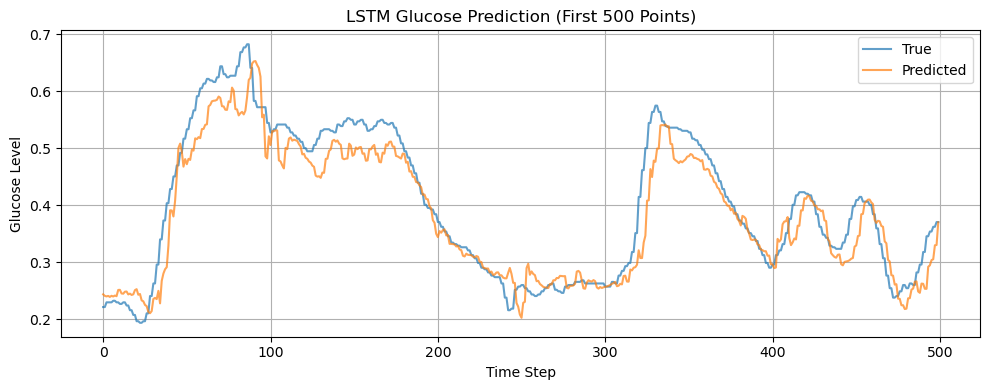

In [126]:
mse, preds, true, mae, r2 = evaluate_lstm_model(model, test_dl)

model three

In [ ]:
#mse_2, preds_2, true_2, mae_2, r2_2 = evaluate_lstm_model(model_2, test_dl)

model three

In [128]:
# Re-import necessary libraries after code execution state reset
import random
from itertools import product

# Define the hyperparameter search space
param_grid = {
    'hidden_size': [32, 64, 128],
    'dropout': [0.2, 0.3, 0.4],
    'learning_rate': [1e-3, 5e-4],
    'batch_size': [32, 64, 128],
    'time_steps': [6, 12]
}

# Generate all possible combinations (full grid)
all_combinations = list(product(
    param_grid['hidden_size'],
    param_grid['dropout'],
    param_grid['learning_rate'],
    param_grid['batch_size'],
    param_grid['time_steps']
))

# Randomly sample a subset of combinations
random.seed(42)
n_samples = 10  # Change this depending on your budget
sampled_combinations = random.sample(all_combinations, n_samples)

sampled_combinations[:5]  # Show the first 5 sampled configurations


[(128, 0.2, 0.0005, 64, 12),
 (32, 0.3, 0.001, 64, 6),
 (32, 0.2, 0.001, 64, 12),
 (128, 0.3, 0.0005, 128, 6),
 (32, 0.4, 0.0005, 128, 12)]

In [129]:
# Define the LSTM model
class GlucoseLSTM_3(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2, dropout=0.3):
        super(GlucoseLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                            dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out.squeeze()


In [130]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import torch

def evaluate_model(model, data_loader, device='cuda' if torch.cuda.is_available() else 'cpu', plot_len=500, verbose=True):
    model.to(device)
    model.eval()

    preds = []
    true = []

    with torch.no_grad():
        for xb, yb in data_loader:
            xb, yb = xb.to(device), yb.to(device)

            output = model(xb)
            if output.ndim > 1:
                output = output.squeeze(-1)

            preds.append(output.cpu().numpy())
            true.append(yb.cpu().numpy())

    # ✅ Use concatenate instead of vstack
    preds = np.concatenate(preds)
    true = np.concatenate(true)

    # Compute metrics
    mse = mean_squared_error(true, preds)
    mae = mean_absolute_error(true, preds)
    r2 = r2_score(true, preds)

    if verbose:
        print(f"📉 Test MSE:  {mse:.4f}")
        print(f"📏 Test MAE:  {mae:.4f}")
        print(f"📈 Test R2 Score: {r2:.4f}")

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(true[:plot_len], label="True")
    plt.plot(preds[:plot_len], label="Predicted")
    plt.legend()
    plt.title(f"Predicted vs True Glucose (First {plot_len} points)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return mse, mae, r2


In [131]:
def train_lstm_model(
    model,
    train_loader,
    val_loader=None,
    epochs=30,
    lr=1e-3,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    patience=5,
    min_delta=1e-4
):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    best_loss = float('inf')
    trigger_times = 0
    history = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        epoch_loss /= len(train_loader)
        history.append(epoch_loss)

        # Validation
        if val_loader:
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for xb_val, yb_val in val_loader:
                    xb_val, yb_val = xb_val.to(device), yb_val.to(device)
                    val_preds = model(xb_val)
                    val_loss += criterion(val_preds, yb_val).item()
            val_loss /= len(val_loader)

            print(f"📉 Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

            # Early stopping
            if val_loss + min_delta < best_loss:
                best_loss = val_loss
                trigger_times = 0
                best_model = model.state_dict()
            else:
                trigger_times += 1
                if trigger_times >= patience:
                    print("🛑 Early stopping triggered.")
                    break
        else:
            print(f"📉 Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}")

    # Load best model if early stopping was triggered
    if val_loader and 'best_model' in locals():
        model.load_state_dict(best_model)

    return model, history


In [132]:
## Hyperparameter tuning loop
def run_random_search(X_seq, y_seq, input_size, configs):
    results = []
    for i, (hidden_size, dropout, lr, batch_size, time_steps) in enumerate(configs):
        print(f"\n🧪 Config {i+1}/{len(configs)}")
        print(f"hidden={hidden_size}, dropout={dropout}, lr={lr}, batch={batch_size}, time_steps={time_steps}")

        # Convert to PyTorch tensors
        X_tensor = torch.from_numpy(X_seq).float()
        y_tensor = torch.from_numpy(y_seq).float()
        dataset = TensorDataset(X_tensor, y_tensor)

        # Train/Val split
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

        # Model
        model = GlucoseLSTM(input_size=input_size, hidden_size=hidden_size, dropout=dropout)

        # Train
        model, _ = train_lstm_model(model, train_loader, val_loader, epochs=30, lr=lr)

        # Evaluate
        mse, mae, r2 = evaluate_model(model, val_loader)
        print(f"✅ MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

        results.append({
            'config': (hidden_size, dropout, lr, batch_size, time_steps),
            'mse': mse,
            'mae': mae,
            'r2': r2
        })

    return results




🧪 Config 1/5
hidden=128, dropout=0.2, lr=0.0005, batch=64, time_steps=12
📉 Epoch 1/30, Train Loss: 0.0085, Val Loss: 0.0046
📉 Epoch 2/30, Train Loss: 0.0045, Val Loss: 0.0040
📉 Epoch 3/30, Train Loss: 0.0039, Val Loss: 0.0033
📉 Epoch 4/30, Train Loss: 0.0035, Val Loss: 0.0032
📉 Epoch 5/30, Train Loss: 0.0034, Val Loss: 0.0031
📉 Epoch 6/30, Train Loss: 0.0033, Val Loss: 0.0033
📉 Epoch 7/30, Train Loss: 0.0032, Val Loss: 0.0031
📉 Epoch 8/30, Train Loss: 0.0032, Val Loss: 0.0031
📉 Epoch 9/30, Train Loss: 0.0031, Val Loss: 0.0030
📉 Epoch 10/30, Train Loss: 0.0031, Val Loss: 0.0030
📉 Epoch 11/30, Train Loss: 0.0030, Val Loss: 0.0029
📉 Epoch 12/30, Train Loss: 0.0030, Val Loss: 0.0031
📉 Epoch 13/30, Train Loss: 0.0030, Val Loss: 0.0029
📉 Epoch 14/30, Train Loss: 0.0030, Val Loss: 0.0028
📉 Epoch 15/30, Train Loss: 0.0029, Val Loss: 0.0029
📉 Epoch 16/30, Train Loss: 0.0029, Val Loss: 0.0029
📉 Epoch 17/30, Train Loss: 0.0029, Val Loss: 0.0030
📉 Epoch 18/30, Train Loss: 0.0029, Val Loss: 0.0028

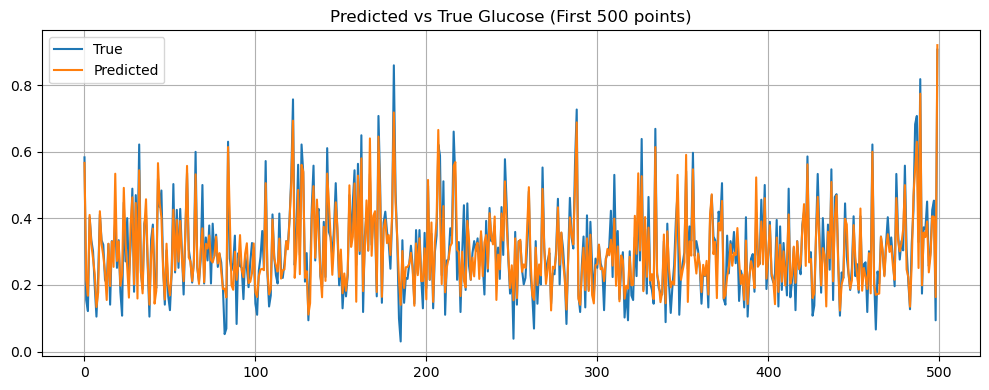

✅ MSE: 0.0029, MAE: 0.0363, R2: 0.8489

🧪 Config 2/5
hidden=32, dropout=0.3, lr=0.001, batch=64, time_steps=6
📉 Epoch 1/30, Train Loss: 0.0075, Val Loss: 0.0047
📉 Epoch 2/30, Train Loss: 0.0047, Val Loss: 0.0037
📉 Epoch 3/30, Train Loss: 0.0038, Val Loss: 0.0035
📉 Epoch 4/30, Train Loss: 0.0036, Val Loss: 0.0034
📉 Epoch 5/30, Train Loss: 0.0034, Val Loss: 0.0030
📉 Epoch 6/30, Train Loss: 0.0034, Val Loss: 0.0031
📉 Epoch 7/30, Train Loss: 0.0033, Val Loss: 0.0031
📉 Epoch 8/30, Train Loss: 0.0032, Val Loss: 0.0029
📉 Epoch 9/30, Train Loss: 0.0032, Val Loss: 0.0028
📉 Epoch 10/30, Train Loss: 0.0032, Val Loss: 0.0029
📉 Epoch 11/30, Train Loss: 0.0031, Val Loss: 0.0029
📉 Epoch 12/30, Train Loss: 0.0031, Val Loss: 0.0028
📉 Epoch 13/30, Train Loss: 0.0031, Val Loss: 0.0028
📉 Epoch 14/30, Train Loss: 0.0031, Val Loss: 0.0028
🛑 Early stopping triggered.
📉 Test MSE:  0.0028
📏 Test MAE:  0.0355
📈 Test R2 Score: 0.8486


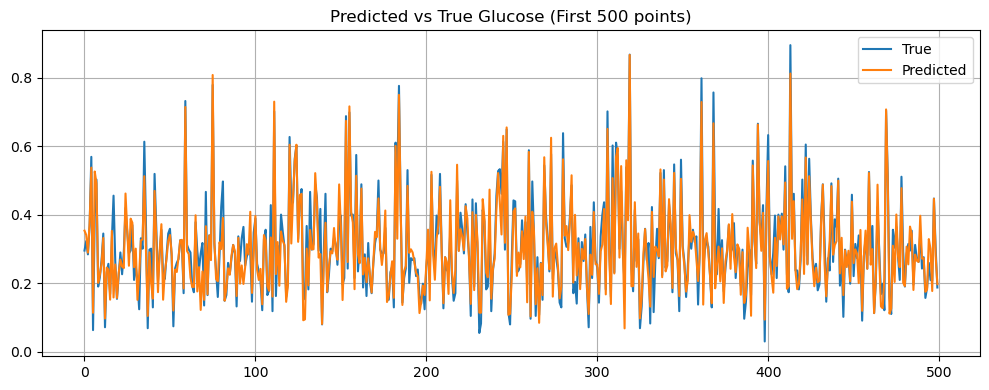

✅ MSE: 0.0028, MAE: 0.0355, R2: 0.8486

🧪 Config 3/5
hidden=32, dropout=0.2, lr=0.001, batch=64, time_steps=12
📉 Epoch 1/30, Train Loss: 0.0067, Val Loss: 0.0042
📉 Epoch 2/30, Train Loss: 0.0042, Val Loss: 0.0039
📉 Epoch 3/30, Train Loss: 0.0036, Val Loss: 0.0035
📉 Epoch 4/30, Train Loss: 0.0034, Val Loss: 0.0031
📉 Epoch 5/30, Train Loss: 0.0033, Val Loss: 0.0030
📉 Epoch 6/30, Train Loss: 0.0032, Val Loss: 0.0031
📉 Epoch 7/30, Train Loss: 0.0032, Val Loss: 0.0031
📉 Epoch 8/30, Train Loss: 0.0031, Val Loss: 0.0030
📉 Epoch 9/30, Train Loss: 0.0031, Val Loss: 0.0030
📉 Epoch 10/30, Train Loss: 0.0030, Val Loss: 0.0028
📉 Epoch 11/30, Train Loss: 0.0030, Val Loss: 0.0030
📉 Epoch 12/30, Train Loss: 0.0030, Val Loss: 0.0028
📉 Epoch 13/30, Train Loss: 0.0030, Val Loss: 0.0028
📉 Epoch 14/30, Train Loss: 0.0030, Val Loss: 0.0027
📉 Epoch 15/30, Train Loss: 0.0029, Val Loss: 0.0028
🛑 Early stopping triggered.
📉 Test MSE:  0.0027
📏 Test MAE:  0.0358
📈 Test R2 Score: 0.8544


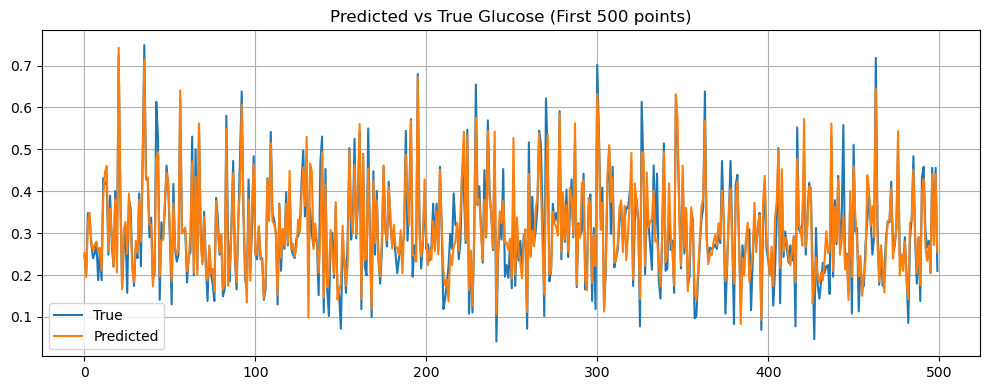

✅ MSE: 0.0027, MAE: 0.0358, R2: 0.8544

🧪 Config 4/5
hidden=128, dropout=0.3, lr=0.0005, batch=128, time_steps=6
📉 Epoch 1/30, Train Loss: 0.0099, Val Loss: 0.0054
📉 Epoch 2/30, Train Loss: 0.0052, Val Loss: 0.0050
📉 Epoch 3/30, Train Loss: 0.0045, Val Loss: 0.0060
📉 Epoch 4/30, Train Loss: 0.0041, Val Loss: 0.0040
📉 Epoch 5/30, Train Loss: 0.0037, Val Loss: 0.0036
📉 Epoch 6/30, Train Loss: 0.0036, Val Loss: 0.0036
📉 Epoch 7/30, Train Loss: 0.0034, Val Loss: 0.0033
📉 Epoch 8/30, Train Loss: 0.0034, Val Loss: 0.0031
📉 Epoch 9/30, Train Loss: 0.0033, Val Loss: 0.0031
📉 Epoch 10/30, Train Loss: 0.0032, Val Loss: 0.0035
📉 Epoch 11/30, Train Loss: 0.0032, Val Loss: 0.0031
📉 Epoch 12/30, Train Loss: 0.0032, Val Loss: 0.0030
📉 Epoch 13/30, Train Loss: 0.0031, Val Loss: 0.0029
📉 Epoch 14/30, Train Loss: 0.0031, Val Loss: 0.0030
📉 Epoch 15/30, Train Loss: 0.0030, Val Loss: 0.0028
📉 Epoch 16/30, Train Loss: 0.0030, Val Loss: 0.0029
📉 Epoch 17/30, Train Loss: 0.0030, Val Loss: 0.0029
📉 Epoch 18/3

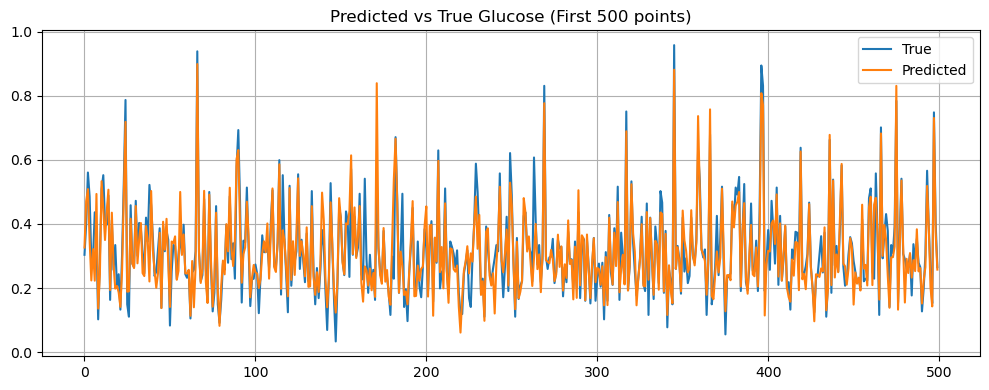

✅ MSE: 0.0028, MAE: 0.0359, R2: 0.8443

🧪 Config 5/5
hidden=32, dropout=0.4, lr=0.0005, batch=128, time_steps=12
📉 Epoch 1/30, Train Loss: 0.0100, Val Loss: 0.0054
📉 Epoch 2/30, Train Loss: 0.0057, Val Loss: 0.0050
📉 Epoch 3/30, Train Loss: 0.0054, Val Loss: 0.0049
📉 Epoch 4/30, Train Loss: 0.0051, Val Loss: 0.0046
📉 Epoch 5/30, Train Loss: 0.0048, Val Loss: 0.0042
📉 Epoch 6/30, Train Loss: 0.0045, Val Loss: 0.0038
📉 Epoch 7/30, Train Loss: 0.0041, Val Loss: 0.0037
📉 Epoch 8/30, Train Loss: 0.0039, Val Loss: 0.0033
📉 Epoch 9/30, Train Loss: 0.0037, Val Loss: 0.0032
📉 Epoch 10/30, Train Loss: 0.0036, Val Loss: 0.0031
📉 Epoch 11/30, Train Loss: 0.0035, Val Loss: 0.0033
📉 Epoch 12/30, Train Loss: 0.0035, Val Loss: 0.0031
📉 Epoch 13/30, Train Loss: 0.0035, Val Loss: 0.0032
📉 Epoch 14/30, Train Loss: 0.0034, Val Loss: 0.0034
📉 Epoch 15/30, Train Loss: 0.0033, Val Loss: 0.0032
📉 Epoch 16/30, Train Loss: 0.0033, Val Loss: 0.0030
📉 Epoch 17/30, Train Loss: 0.0033, Val Loss: 0.0031
🛑 Early stop

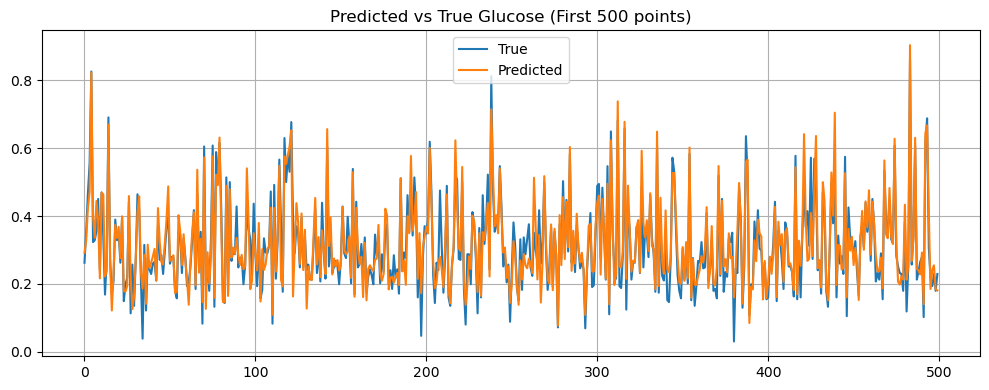

✅ MSE: 0.0031, MAE: 0.0378, R2: 0.8301


In [133]:
# Example
configs = [
    (128, 0.2, 0.0005, 64, 12),
    (32, 0.3, 0.001, 64, 6),
    (32, 0.2, 0.001, 64, 12),
    (128, 0.3, 0.0005, 128, 6),
    (32, 0.4, 0.0005, 128, 12)
]

# Call the search
results = run_random_search(X, y, input_size=X.shape[2], configs=configs)



🧪 Config 1/5
hidden=128, dropout=0.15, lr=0.0005, batch=64, time_steps=12
📉 Epoch 1/30, Train Loss: 0.0077, Val Loss: 0.0048
📉 Epoch 2/30, Train Loss: 0.0043, Val Loss: 0.0037
📉 Epoch 3/30, Train Loss: 0.0038, Val Loss: 0.0034
📉 Epoch 4/30, Train Loss: 0.0035, Val Loss: 0.0031
📉 Epoch 5/30, Train Loss: 0.0033, Val Loss: 0.0030
📉 Epoch 6/30, Train Loss: 0.0033, Val Loss: 0.0031
📉 Epoch 7/30, Train Loss: 0.0032, Val Loss: 0.0030
📉 Epoch 8/30, Train Loss: 0.0031, Val Loss: 0.0030
📉 Epoch 9/30, Train Loss: 0.0031, Val Loss: 0.0029
📉 Epoch 10/30, Train Loss: 0.0030, Val Loss: 0.0029
📉 Epoch 11/30, Train Loss: 0.0030, Val Loss: 0.0028
📉 Epoch 12/30, Train Loss: 0.0030, Val Loss: 0.0029
📉 Epoch 13/30, Train Loss: 0.0029, Val Loss: 0.0028
📉 Epoch 14/30, Train Loss: 0.0029, Val Loss: 0.0028
📉 Epoch 15/30, Train Loss: 0.0029, Val Loss: 0.0027
📉 Epoch 16/30, Train Loss: 0.0029, Val Loss: 0.0028
🛑 Early stopping triggered.
📉 Test MSE:  0.0028
📏 Test MAE:  0.0350
📈 Test R2 Score: 0.8473


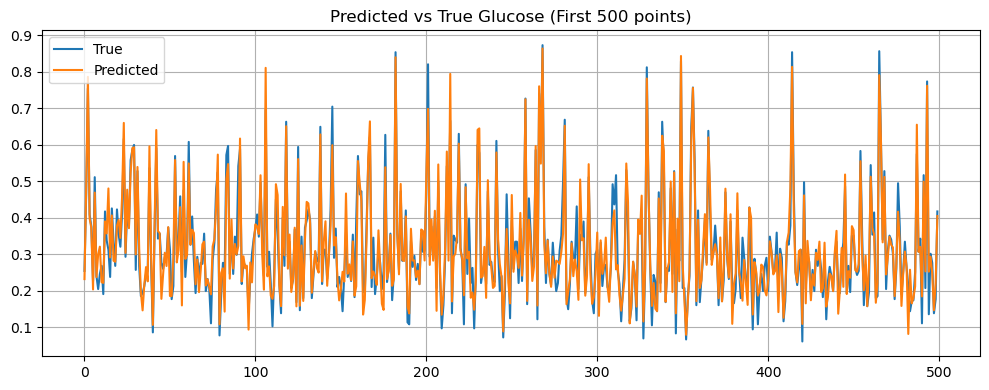

📉 Test MSE:  0.0028
📏 Test MAE:  0.0350
📈 Test R2:   0.8473

🧪 Config 2/5
hidden=128, dropout=0.25, lr=0.0003, batch=64, time_steps=12
📉 Epoch 1/30, Train Loss: 0.0081, Val Loss: 0.0052
📉 Epoch 2/30, Train Loss: 0.0049, Val Loss: 0.0043
📉 Epoch 3/30, Train Loss: 0.0041, Val Loss: 0.0039
📉 Epoch 4/30, Train Loss: 0.0038, Val Loss: 0.0035
📉 Epoch 5/30, Train Loss: 0.0035, Val Loss: 0.0038
📉 Epoch 6/30, Train Loss: 0.0034, Val Loss: 0.0034
📉 Epoch 7/30, Train Loss: 0.0033, Val Loss: 0.0033
📉 Epoch 8/30, Train Loss: 0.0032, Val Loss: 0.0037
📉 Epoch 9/30, Train Loss: 0.0032, Val Loss: 0.0032
📉 Epoch 10/30, Train Loss: 0.0031, Val Loss: 0.0032
📉 Epoch 11/30, Train Loss: 0.0031, Val Loss: 0.0031
📉 Epoch 12/30, Train Loss: 0.0030, Val Loss: 0.0031
📉 Epoch 13/30, Train Loss: 0.0030, Val Loss: 0.0032
📉 Epoch 14/30, Train Loss: 0.0030, Val Loss: 0.0030
📉 Epoch 15/30, Train Loss: 0.0029, Val Loss: 0.0032
📉 Epoch 16/30, Train Loss: 0.0029, Val Loss: 0.0030
📉 Epoch 17/30, Train Loss: 0.0029, Val Los

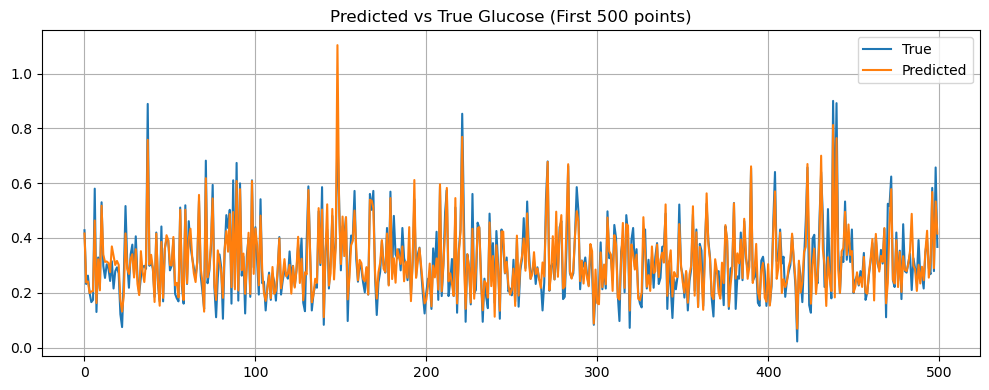

📉 Test MSE:  0.0030
📏 Test MAE:  0.0361
📈 Test R2:   0.8415

🧪 Config 3/5
hidden=256, dropout=0.2, lr=0.0005, batch=64, time_steps=12
📉 Epoch 1/30, Train Loss: 0.0068, Val Loss: 0.0042
📉 Epoch 2/30, Train Loss: 0.0040, Val Loss: 0.0034
📉 Epoch 3/30, Train Loss: 0.0036, Val Loss: 0.0032
📉 Epoch 4/30, Train Loss: 0.0034, Val Loss: 0.0033
📉 Epoch 5/30, Train Loss: 0.0033, Val Loss: 0.0031
📉 Epoch 6/30, Train Loss: 0.0032, Val Loss: 0.0030
📉 Epoch 7/30, Train Loss: 0.0032, Val Loss: 0.0029
📉 Epoch 8/30, Train Loss: 0.0031, Val Loss: 0.0030
📉 Epoch 9/30, Train Loss: 0.0030, Val Loss: 0.0029
📉 Epoch 10/30, Train Loss: 0.0030, Val Loss: 0.0029
📉 Epoch 11/30, Train Loss: 0.0029, Val Loss: 0.0029
📉 Epoch 12/30, Train Loss: 0.0029, Val Loss: 0.0029
📉 Epoch 13/30, Train Loss: 0.0029, Val Loss: 0.0029
📉 Epoch 14/30, Train Loss: 0.0029, Val Loss: 0.0028
📉 Epoch 15/30, Train Loss: 0.0029, Val Loss: 0.0028
📉 Epoch 16/30, Train Loss: 0.0028, Val Loss: 0.0029
🛑 Early stopping triggered.
📉 Test MSE:  0.

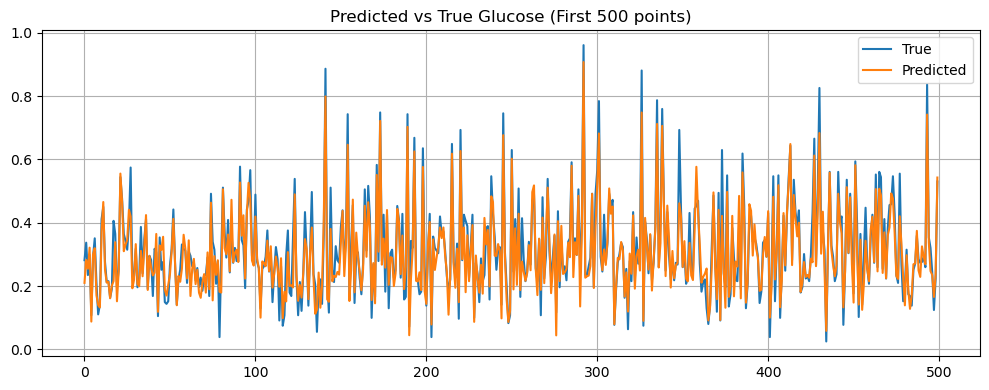

📉 Test MSE:  0.0029
📏 Test MAE:  0.0363
📈 Test R2:   0.8453

🧪 Config 4/5
hidden=128, dropout=0.2, lr=0.0005, batch=32, time_steps=12
📉 Epoch 1/30, Train Loss: 0.0062, Val Loss: 0.0038
📉 Epoch 2/30, Train Loss: 0.0038, Val Loss: 0.0033
📉 Epoch 3/30, Train Loss: 0.0034, Val Loss: 0.0031
📉 Epoch 4/30, Train Loss: 0.0033, Val Loss: 0.0032
📉 Epoch 5/30, Train Loss: 0.0032, Val Loss: 0.0030
📉 Epoch 6/30, Train Loss: 0.0031, Val Loss: 0.0030
📉 Epoch 7/30, Train Loss: 0.0031, Val Loss: 0.0030
📉 Epoch 8/30, Train Loss: 0.0030, Val Loss: 0.0031
📉 Epoch 9/30, Train Loss: 0.0030, Val Loss: 0.0029
📉 Epoch 10/30, Train Loss: 0.0030, Val Loss: 0.0029
📉 Epoch 11/30, Train Loss: 0.0029, Val Loss: 0.0028
📉 Epoch 12/30, Train Loss: 0.0029, Val Loss: 0.0028
📉 Epoch 13/30, Train Loss: 0.0028, Val Loss: 0.0028
📉 Epoch 14/30, Train Loss: 0.0028, Val Loss: 0.0029
📉 Epoch 15/30, Train Loss: 0.0028, Val Loss: 0.0027
📉 Epoch 16/30, Train Loss: 0.0028, Val Loss: 0.0028
📉 Epoch 17/30, Train Loss: 0.0027, Val Loss

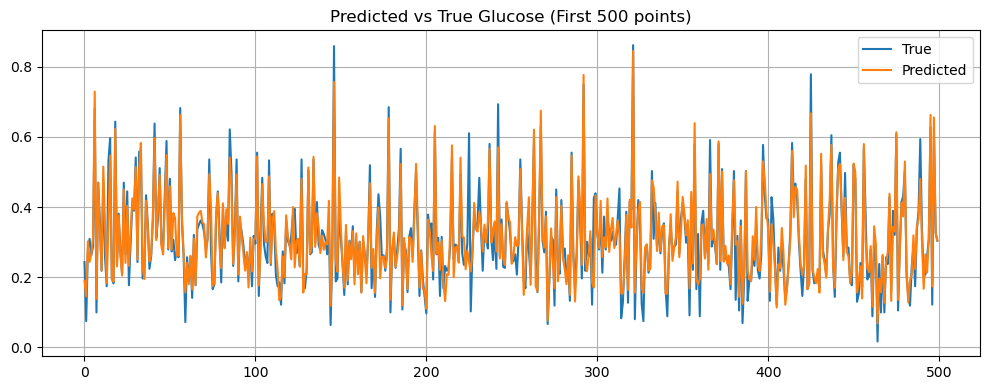

📉 Test MSE:  0.0027
📏 Test MAE:  0.0338
📈 Test R2:   0.8558

🧪 Config 5/5
hidden=128, dropout=0.2, lr=0.0007, batch=64, time_steps=12
📉 Epoch 1/30, Train Loss: 0.0063, Val Loss: 0.0042
📉 Epoch 2/30, Train Loss: 0.0039, Val Loss: 0.0034
📉 Epoch 3/30, Train Loss: 0.0035, Val Loss: 0.0031
📉 Epoch 4/30, Train Loss: 0.0033, Val Loss: 0.0031
📉 Epoch 5/30, Train Loss: 0.0032, Val Loss: 0.0030
📉 Epoch 6/30, Train Loss: 0.0032, Val Loss: 0.0036
📉 Epoch 7/30, Train Loss: 0.0031, Val Loss: 0.0029
📉 Epoch 8/30, Train Loss: 0.0030, Val Loss: 0.0028
📉 Epoch 9/30, Train Loss: 0.0030, Val Loss: 0.0029
📉 Epoch 10/30, Train Loss: 0.0030, Val Loss: 0.0028
📉 Epoch 11/30, Train Loss: 0.0029, Val Loss: 0.0028
📉 Epoch 12/30, Train Loss: 0.0029, Val Loss: 0.0027
📉 Epoch 13/30, Train Loss: 0.0029, Val Loss: 0.0027
🛑 Early stopping triggered.
📉 Test MSE:  0.0027
📏 Test MAE:  0.0353
📈 Test R2 Score: 0.8542


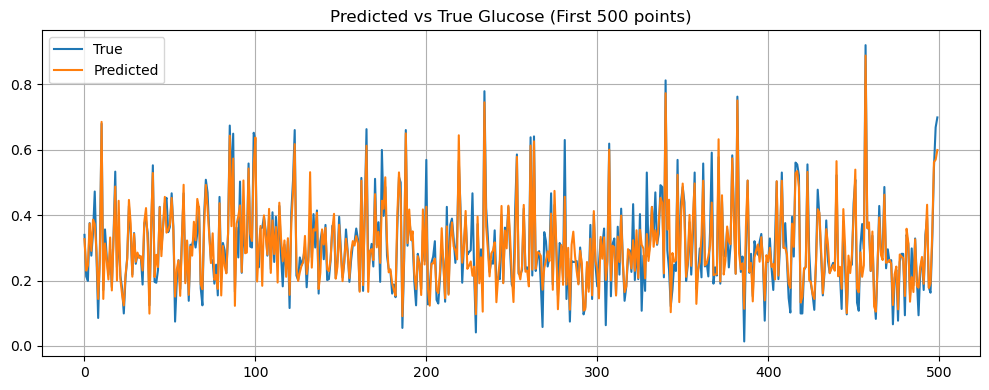

📉 Test MSE:  0.0027
📏 Test MAE:  0.0353
📈 Test R2:   0.8542

🏆 Sorted results by R²:
{'config': (128, 0.2, 0.0005, 32, 12), 'mse': 0.002651677932590246, 'mae': 0.03379039838910103, 'r2': 0.8557642698287964}
{'config': (128, 0.2, 0.0007, 64, 12), 'mse': 0.002727965824306011, 'mae': 0.0352504625916481, 'r2': 0.8542472124099731}
{'config': (128, 0.15, 0.0005, 64, 12), 'mse': 0.0028197348583489656, 'mae': 0.03502614423632622, 'r2': 0.8473475575447083}
{'config': (256, 0.2, 0.0005, 64, 12), 'mse': 0.002899766666814685, 'mae': 0.03627202287316322, 'r2': 0.8453093767166138}
{'config': (128, 0.25, 0.0003, 64, 12), 'mse': 0.0030288437847048044, 'mae': 0.036148957908153534, 'r2': 0.8415166139602661}


In [134]:
# New configs based on your current best
new_configs = [
    (128, 0.15, 0.0005, 64, 12),  # A: Slightly less dropout
    (128, 0.25, 0.0003, 64, 12),  # B: More dropout + smaller LR
    (256, 0.2, 0.0005, 64, 12),   # C: Larger hidden size
    (128, 0.2, 0.0005, 32, 12),   # D: Smaller batch size
    (128, 0.2, 0.0007, 64, 12),   # E: Slightly bigger LR
]

def run_random_search(X_seq, y_seq, input_size, configs):
    results = []
    for i, (hidden_size, dropout, lr, batch_size, time_steps) in enumerate(configs):
        print(f"\n🧪 Config {i+1}/{len(configs)}")
        print(f"hidden={hidden_size}, dropout={dropout}, lr={lr}, batch={batch_size}, time_steps={time_steps}")

        # Convert to PyTorch tensors
        X_tensor = torch.from_numpy(X_seq).float()
        y_tensor = torch.from_numpy(y_seq).float()
        dataset = TensorDataset(X_tensor, y_tensor)

        # Train/Val split
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

        # Model
        model = GlucoseLSTM(input_size=input_size, hidden_size=hidden_size, dropout=dropout)

        # Train
        model, _ = train_lstm_model(model, train_loader, val_loader, epochs=30, lr=lr)

        # Evaluate
        mse, mae, r2 = evaluate_model(model, val_loader)
        print(f"📉 Test MSE:  {mse:.4f}")
        print(f"📏 Test MAE:  {mae:.4f}")
        print(f"📈 Test R2:   {r2:.4f}")

        results.append({
            'config': (hidden_size, dropout, lr, batch_size, time_steps),
            'mse': mse,
            'mae': mae,
            'r2': r2
        })

    return results

# Run the search
results_new = run_random_search(X, y, input_size=X.shape[2], configs=new_configs)

# Sort by best R²
results_new = sorted(results_new, key=lambda x: x['r2'], reverse=True)

print("\n🏆 Sorted results by R²:")
for r in results_new:
    print(r)


In [135]:
import joblib
import torch

# 🔍 Step 1: Find best result based on R2 or lowest MSE
def select_best_model(results, metric='r2'):
    sorted_results = sorted(results, key=lambda x: -x[metric] if metric == 'r2' else x[metric])
    best = sorted_results[0]
    print(f"\n🏆 Best Config: {best['config']}")
    print(f"📉 MSE: {best['mse']:.4f}, MAE: {best['mae']:.4f}, R2: {best['r2']:.4f}")
    return best

# 🧠 Step 2: Retrain the best model on full data
def retrain_best_model(X_seq, y_seq, input_size, config, epochs=30):
    hidden_size, dropout, lr, batch_size, time_steps = config

    dataset = TensorDataset(torch.from_numpy(X_seq).float(), torch.from_numpy(y_seq).float())
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = GlucoseLSTM(input_size=input_size, hidden_size=hidden_size, dropout=dropout)
    model, history = train_lstm_model(model, loader, val_loader=None, epochs=epochs, lr=lr)
    return model

# 💾 Step 3: Save trained model
def save_model(model, path="glucose_lstm_best_model.pt"):
    torch.save(model.state_dict(), path)
    print(f"✅ Model saved to {path}")


In [136]:
# Step 1: Pick best model from results
best_result = select_best_model(results, metric='r2')

# Step 2: Retrain it fully
best_model = retrain_best_model(X, y, input_size=X.shape[2], config=best_result['config'], epochs=30)

# Step 3: Save the model
save_model(best_model, path="glucose_lstm_best_model.pt")



🏆 Best Config: (32, 0.2, 0.001, 64, 12)
📉 MSE: 0.0027, MAE: 0.0358, R2: 0.8544
📉 Epoch 1/30, Train Loss: 0.0092
📉 Epoch 2/30, Train Loss: 0.0041
📉 Epoch 3/30, Train Loss: 0.0035
📉 Epoch 4/30, Train Loss: 0.0034
📉 Epoch 5/30, Train Loss: 0.0032
📉 Epoch 6/30, Train Loss: 0.0032
📉 Epoch 7/30, Train Loss: 0.0031
📉 Epoch 8/30, Train Loss: 0.0031
📉 Epoch 9/30, Train Loss: 0.0031
📉 Epoch 10/30, Train Loss: 0.0030
📉 Epoch 11/30, Train Loss: 0.0030
📉 Epoch 12/30, Train Loss: 0.0030
📉 Epoch 13/30, Train Loss: 0.0029
📉 Epoch 14/30, Train Loss: 0.0029
📉 Epoch 15/30, Train Loss: 0.0029
📉 Epoch 16/30, Train Loss: 0.0029
📉 Epoch 17/30, Train Loss: 0.0029
📉 Epoch 18/30, Train Loss: 0.0028
📉 Epoch 19/30, Train Loss: 0.0028
📉 Epoch 20/30, Train Loss: 0.0028
📉 Epoch 21/30, Train Loss: 0.0028
📉 Epoch 22/30, Train Loss: 0.0028
📉 Epoch 23/30, Train Loss: 0.0027
📉 Epoch 24/30, Train Loss: 0.0027
📉 Epoch 25/30, Train Loss: 0.0027
📉 Epoch 26/30, Train Loss: 0.0027
📉 Epoch 27/30, Train Loss: 0.0027
📉 Epoch 28/

model four

In [138]:
# 1️⃣ Model Definition
# ----------------------
class LSTMModel_4(nn.Module):
    def __init__(self, input_size, hidden_size, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out


In [139]:
# ----------------------
# 2️⃣ Training Function
# ----------------------
def train_model_4(model, train_loader, val_loader, config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    best_val_loss = float("inf")
    patience_counter = 0
    best_model_state = None

    for epoch in range(30):
        model.train()
        train_losses = []
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # gradient clipping
            optimizer.step()
            train_losses.append(loss.item())

        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                loss = criterion(outputs, y_val)
                val_losses.append(loss.item())

        val_loss = np.mean(val_losses)
        scheduler.step(val_loss)

        print(f"📉 Epoch {epoch+1}/30, Train Loss: {np.mean(train_losses):.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 5:
                print("🛑 Early stopping triggered.")
                break

    model.load_state_dict(best_model_state)
    return model


In [140]:
# ----------------------
def evaluate_model_4(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            outputs = model(X_test)
            preds.extend(outputs.cpu().numpy())
            trues.extend(y_test.cpu().numpy())

    mse = mean_squared_error(trues, preds)
    mae = mean_absolute_error(trues, preds)
    r2 = r2_score(trues, preds)
    return mse, mae, r2

In [141]:
# 4️⃣ Configurations
# ----------------------
configs = [
    {"hidden": 128, "dropout": 0.15, "lr": 0.0004},
    {"hidden": 128, "dropout": 0.15, "lr": 0.0005},
    {"hidden": 128, "dropout": 0.18, "lr": 0.0004},
    {"hidden": 128, "dropout": 0.18, "lr": 0.0005},
    {"hidden": 128, "dropout": 0.15, "lr": 0.0006},
    {"hidden": 128, "dropout": 0.18, "lr": 0.0006},
]

model five

In [143]:
import itertools
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split

# ==== Define LSTM Model ====
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out



# 1️⃣ Train/Val/Test split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15, shuffle=False)

# 2️⃣ Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)



# ==== Training Function ====
def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test,
                       hidden_size, dropout, lr, batch_size, time_steps):

    # Create dataloaders
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

    model = LSTMModel(X_train.shape[2], hidden_size, dropout)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_loss = np.inf
    patience = 5
    trigger_times = 0

    for epoch in range(30):
        model.train()
        train_losses = []
        for Xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(Xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for Xb, yb in val_loader:
                pred = model(Xb)
                loss = criterion(pred, yb)
                val_losses.append(loss.item())

        val_loss = np.mean(val_losses)
        print(f"Epoch {epoch+1}, Train Loss: {np.mean(train_losses):.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
            best_model = model.state_dict()
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Early stopping.")
                break

    # Load best model
    model.load_state_dict(best_model)

    # Evaluate on test
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for Xb, yb in test_loader:
            pred = model(Xb)
            preds.extend(pred.numpy())
            trues.extend(yb.numpy())

    mse = mean_squared_error(trues, preds)
    mae = mean_absolute_error(trues, preds)
    r2 = r2_score(trues, preds)
    return mse, mae, r2

# ==== Micro Search ====
hidden_options = [32, 48, 64]
dropout_options = [0.18, 0.20, 0.22, 0.25]
lr_options = [0.0009, 0.0010, 0.0011]
batch_options = [64, 96]
time_steps = [12]  # fixed

best_score = -np.inf
best_config = None

for hidden, dropout, lr, batch in itertools.product(hidden_options, dropout_options, lr_options, batch_options):
    print(f"Testing config: hidden={hidden}, dropout={dropout}, lr={lr}, batch={batch}")
    mse, mae, r2 = train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test,
                                      hidden, dropout, lr, batch, time_steps[0])
    print(f"MSE={mse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")
    if r2 > best_score:
        best_score = r2
        best_config = (hidden, dropout, lr, batch, time_steps[0])

print(f"\nBest Config: {best_config}, R2={best_score:.4f}")


Testing config: hidden=32, dropout=0.18, lr=0.0009, batch=64


C:\Users\HP\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.18 and num_layers=1
  warnings.warn(


Epoch 1, Train Loss: 0.0069, Val Loss: 0.0024
Epoch 2, Train Loss: 0.0043, Val Loss: 0.0021
Epoch 3, Train Loss: 0.0037, Val Loss: 0.0021
Epoch 4, Train Loss: 0.0034, Val Loss: 0.0017
Epoch 5, Train Loss: 0.0032, Val Loss: 0.0015
Epoch 6, Train Loss: 0.0032, Val Loss: 0.0015
Epoch 7, Train Loss: 0.0032, Val Loss: 0.0014
Epoch 8, Train Loss: 0.0031, Val Loss: 0.0014
Epoch 9, Train Loss: 0.0031, Val Loss: 0.0014
Epoch 10, Train Loss: 0.0031, Val Loss: 0.0015
Epoch 11, Train Loss: 0.0030, Val Loss: 0.0015
Epoch 12, Train Loss: 0.0030, Val Loss: 0.0016
Epoch 13, Train Loss: 0.0030, Val Loss: 0.0014
Epoch 14, Train Loss: 0.0029, Val Loss: 0.0014
Early stopping.
MSE=0.0042, MAE=0.0428, R2=0.8155
Testing config: hidden=32, dropout=0.18, lr=0.0009, batch=96


C:\Users\HP\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.18 and num_layers=1
  warnings.warn(


Epoch 1, Train Loss: 0.0120, Val Loss: 0.0030
Epoch 2, Train Loss: 0.0047, Val Loss: 0.0022
Epoch 3, Train Loss: 0.0041, Val Loss: 0.0021
Epoch 4, Train Loss: 0.0037, Val Loss: 0.0016
Epoch 5, Train Loss: 0.0035, Val Loss: 0.0017
Epoch 6, Train Loss: 0.0034, Val Loss: 0.0016
Epoch 7, Train Loss: 0.0033, Val Loss: 0.0015
Epoch 8, Train Loss: 0.0033, Val Loss: 0.0014
Epoch 9, Train Loss: 0.0032, Val Loss: 0.0014
Epoch 10, Train Loss: 0.0032, Val Loss: 0.0015
Epoch 11, Train Loss: 0.0032, Val Loss: 0.0014
Epoch 12, Train Loss: 0.0032, Val Loss: 0.0014
Epoch 13, Train Loss: 0.0031, Val Loss: 0.0016
Epoch 14, Train Loss: 0.0031, Val Loss: 0.0014
Epoch 15, Train Loss: 0.0031, Val Loss: 0.0014
Epoch 16, Train Loss: 0.0030, Val Loss: 0.0014
Epoch 17, Train Loss: 0.0030, Val Loss: 0.0014
Epoch 18, Train Loss: 0.0030, Val Loss: 0.0015
Epoch 19, Train Loss: 0.0030, Val Loss: 0.0014
Epoch 20, Train Loss: 0.0029, Val Loss: 0.0014
Epoch 21, Train Loss: 0.0029, Val Loss: 0.0014
Epoch 22, Train Loss: 

C:\Users\HP\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.18 and num_layers=1
  warnings.warn(


Epoch 1, Train Loss: 0.0067, Val Loss: 0.0023
Epoch 2, Train Loss: 0.0041, Val Loss: 0.0026
Epoch 3, Train Loss: 0.0035, Val Loss: 0.0021
Epoch 4, Train Loss: 0.0034, Val Loss: 0.0015
Epoch 5, Train Loss: 0.0032, Val Loss: 0.0015
Epoch 6, Train Loss: 0.0032, Val Loss: 0.0016
Epoch 7, Train Loss: 0.0032, Val Loss: 0.0015
Epoch 8, Train Loss: 0.0031, Val Loss: 0.0015
Epoch 9, Train Loss: 0.0031, Val Loss: 0.0014
Epoch 10, Train Loss: 0.0030, Val Loss: 0.0016
Epoch 11, Train Loss: 0.0030, Val Loss: 0.0014
Epoch 12, Train Loss: 0.0030, Val Loss: 0.0015
Epoch 13, Train Loss: 0.0030, Val Loss: 0.0014
Epoch 14, Train Loss: 0.0029, Val Loss: 0.0014
Epoch 15, Train Loss: 0.0029, Val Loss: 0.0015
Epoch 16, Train Loss: 0.0029, Val Loss: 0.0015
Epoch 17, Train Loss: 0.0029, Val Loss: 0.0015
Epoch 18, Train Loss: 0.0028, Val Loss: 0.0015
Early stopping.
MSE=0.0044, MAE=0.0448, R2=0.8069
Testing config: hidden=32, dropout=0.18, lr=0.001, batch=96


C:\Users\HP\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.18 and num_layers=1
  warnings.warn(


Epoch 1, Train Loss: 0.0097, Val Loss: 0.0025
Epoch 2, Train Loss: 0.0046, Val Loss: 0.0023
Epoch 3, Train Loss: 0.0041, Val Loss: 0.0020
Epoch 4, Train Loss: 0.0037, Val Loss: 0.0019
Epoch 5, Train Loss: 0.0034, Val Loss: 0.0017
Epoch 6, Train Loss: 0.0033, Val Loss: 0.0015
Epoch 7, Train Loss: 0.0032, Val Loss: 0.0014
Epoch 8, Train Loss: 0.0032, Val Loss: 0.0015
Epoch 9, Train Loss: 0.0032, Val Loss: 0.0014
Epoch 10, Train Loss: 0.0031, Val Loss: 0.0014
Epoch 11, Train Loss: 0.0031, Val Loss: 0.0019
Epoch 12, Train Loss: 0.0031, Val Loss: 0.0016
Epoch 13, Train Loss: 0.0030, Val Loss: 0.0015
Epoch 14, Train Loss: 0.0030, Val Loss: 0.0014
Epoch 15, Train Loss: 0.0030, Val Loss: 0.0014
Early stopping.
MSE=0.0042, MAE=0.0433, R2=0.8144
Testing config: hidden=32, dropout=0.18, lr=0.0011, batch=64


C:\Users\HP\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.18 and num_layers=1
  warnings.warn(


Epoch 1, Train Loss: 0.0068, Val Loss: 0.0022
Epoch 2, Train Loss: 0.0039, Val Loss: 0.0020
Epoch 3, Train Loss: 0.0034, Val Loss: 0.0016
Epoch 4, Train Loss: 0.0033, Val Loss: 0.0017
Epoch 5, Train Loss: 0.0032, Val Loss: 0.0016
Epoch 6, Train Loss: 0.0032, Val Loss: 0.0014
Epoch 7, Train Loss: 0.0031, Val Loss: 0.0014
Epoch 8, Train Loss: 0.0031, Val Loss: 0.0014
Epoch 9, Train Loss: 0.0030, Val Loss: 0.0015
Epoch 10, Train Loss: 0.0030, Val Loss: 0.0014
Epoch 11, Train Loss: 0.0030, Val Loss: 0.0015
Epoch 12, Train Loss: 0.0029, Val Loss: 0.0015
Epoch 13, Train Loss: 0.0029, Val Loss: 0.0015
Epoch 14, Train Loss: 0.0029, Val Loss: 0.0014
Epoch 15, Train Loss: 0.0029, Val Loss: 0.0016
Early stopping.
MSE=0.0045, MAE=0.0461, R2=0.8021
Testing config: hidden=32, dropout=0.18, lr=0.0011, batch=96


C:\Users\HP\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.18 and num_layers=1
  warnings.warn(


Epoch 1, Train Loss: 0.0076, Val Loss: 0.0023
Epoch 2, Train Loss: 0.0043, Val Loss: 0.0019
Epoch 3, Train Loss: 0.0037, Val Loss: 0.0017
Epoch 4, Train Loss: 0.0034, Val Loss: 0.0015
Epoch 5, Train Loss: 0.0032, Val Loss: 0.0014
Epoch 6, Train Loss: 0.0032, Val Loss: 0.0014
Epoch 7, Train Loss: 0.0032, Val Loss: 0.0016
Epoch 8, Train Loss: 0.0031, Val Loss: 0.0014
Epoch 9, Train Loss: 0.0031, Val Loss: 0.0014
Epoch 10, Train Loss: 0.0030, Val Loss: 0.0014
Epoch 11, Train Loss: 0.0030, Val Loss: 0.0017
Epoch 12, Train Loss: 0.0030, Val Loss: 0.0017
Epoch 13, Train Loss: 0.0030, Val Loss: 0.0014
Early stopping.
MSE=0.0043, MAE=0.0442, R2=0.8105
Testing config: hidden=32, dropout=0.2, lr=0.0009, batch=64


C:\Users\HP\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1, Train Loss: 0.0074, Val Loss: 0.0028
Epoch 2, Train Loss: 0.0041, Val Loss: 0.0019
Epoch 3, Train Loss: 0.0035, Val Loss: 0.0016
Epoch 4, Train Loss: 0.0034, Val Loss: 0.0020
Epoch 5, Train Loss: 0.0033, Val Loss: 0.0014
Epoch 6, Train Loss: 0.0032, Val Loss: 0.0015
Epoch 7, Train Loss: 0.0031, Val Loss: 0.0015
Epoch 8, Train Loss: 0.0031, Val Loss: 0.0014
Epoch 9, Train Loss: 0.0030, Val Loss: 0.0016
Epoch 10, Train Loss: 0.0030, Val Loss: 0.0014
Epoch 11, Train Loss: 0.0030, Val Loss: 0.0015
Epoch 12, Train Loss: 0.0030, Val Loss: 0.0015
Epoch 13, Train Loss: 0.0029, Val Loss: 0.0015
Epoch 14, Train Loss: 0.0029, Val Loss: 0.0016
Epoch 15, Train Loss: 0.0029, Val Loss: 0.0014
Early stopping.
MSE=0.0042, MAE=0.0434, R2=0.8138
Testing config: hidden=32, dropout=0.2, lr=0.0009, batch=96


C:\Users\HP\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1, Train Loss: 0.0078, Val Loss: 0.0027
Epoch 2, Train Loss: 0.0044, Val Loss: 0.0023
Epoch 3, Train Loss: 0.0038, Val Loss: 0.0018
Epoch 4, Train Loss: 0.0035, Val Loss: 0.0016
Epoch 5, Train Loss: 0.0033, Val Loss: 0.0015
Epoch 6, Train Loss: 0.0032, Val Loss: 0.0015
Epoch 7, Train Loss: 0.0032, Val Loss: 0.0015
Epoch 8, Train Loss: 0.0031, Val Loss: 0.0016
Epoch 9, Train Loss: 0.0031, Val Loss: 0.0014
Epoch 10, Train Loss: 0.0031, Val Loss: 0.0015
Epoch 11, Train Loss: 0.0030, Val Loss: 0.0015
Epoch 12, Train Loss: 0.0030, Val Loss: 0.0014
Epoch 13, Train Loss: 0.0030, Val Loss: 0.0014
Epoch 14, Train Loss: 0.0030, Val Loss: 0.0015
Early stopping.
MSE=0.0043, MAE=0.0436, R2=0.8115
Testing config: hidden=32, dropout=0.2, lr=0.001, batch=64


C:\Users\HP\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1, Train Loss: 0.0067, Val Loss: 0.0022
Epoch 2, Train Loss: 0.0041, Val Loss: 0.0018
Epoch 3, Train Loss: 0.0035, Val Loss: 0.0018
Epoch 4, Train Loss: 0.0034, Val Loss: 0.0015
Epoch 5, Train Loss: 0.0032, Val Loss: 0.0014
Epoch 6, Train Loss: 0.0032, Val Loss: 0.0015
Epoch 7, Train Loss: 0.0032, Val Loss: 0.0015
Epoch 8, Train Loss: 0.0031, Val Loss: 0.0015
Epoch 9, Train Loss: 0.0031, Val Loss: 0.0014
Epoch 10, Train Loss: 0.0030, Val Loss: 0.0015
Early stopping.
MSE=0.0042, MAE=0.0438, R2=0.8131
Testing config: hidden=32, dropout=0.2, lr=0.001, batch=96


C:\Users\HP\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1, Train Loss: 0.0084, Val Loss: 0.0025
Epoch 2, Train Loss: 0.0044, Val Loss: 0.0021
Epoch 3, Train Loss: 0.0039, Val Loss: 0.0018
Epoch 4, Train Loss: 0.0035, Val Loss: 0.0016
Epoch 5, Train Loss: 0.0034, Val Loss: 0.0016
Epoch 6, Train Loss: 0.0033, Val Loss: 0.0015
Epoch 7, Train Loss: 0.0032, Val Loss: 0.0016
Epoch 8, Train Loss: 0.0032, Val Loss: 0.0018
Epoch 9, Train Loss: 0.0031, Val Loss: 0.0015
Epoch 10, Train Loss: 0.0031, Val Loss: 0.0014
Epoch 11, Train Loss: 0.0030, Val Loss: 0.0015
Epoch 12, Train Loss: 0.0030, Val Loss: 0.0015
Epoch 13, Train Loss: 0.0029, Val Loss: 0.0014
Epoch 14, Train Loss: 0.0029, Val Loss: 0.0015
Epoch 15, Train Loss: 0.0029, Val Loss: 0.0014
Epoch 16, Train Loss: 0.0029, Val Loss: 0.0014
Epoch 17, Train Loss: 0.0029, Val Loss: 0.0015
Epoch 18, Train Loss: 0.0028, Val Loss: 0.0016
Epoch 19, Train Loss: 0.0028, Val Loss: 0.0015
Epoch 20, Train Loss: 0.0028, Val Loss: 0.0014
Epoch 21, Train Loss: 0.0028, Val Loss: 0.0015
Early stopping.
MSE=0.

C:\Users\HP\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1, Train Loss: 0.0070, Val Loss: 0.0023
Epoch 2, Train Loss: 0.0040, Val Loss: 0.0021
Epoch 3, Train Loss: 0.0035, Val Loss: 0.0017
Epoch 4, Train Loss: 0.0033, Val Loss: 0.0015
Epoch 5, Train Loss: 0.0033, Val Loss: 0.0016
Epoch 6, Train Loss: 0.0032, Val Loss: 0.0015
Epoch 7, Train Loss: 0.0031, Val Loss: 0.0017
Epoch 8, Train Loss: 0.0031, Val Loss: 0.0015
Epoch 9, Train Loss: 0.0030, Val Loss: 0.0019
Epoch 10, Train Loss: 0.0030, Val Loss: 0.0015
Epoch 11, Train Loss: 0.0030, Val Loss: 0.0016
Epoch 12, Train Loss: 0.0030, Val Loss: 0.0016
Epoch 13, Train Loss: 0.0029, Val Loss: 0.0014
Epoch 14, Train Loss: 0.0029, Val Loss: 0.0015
Epoch 15, Train Loss: 0.0029, Val Loss: 0.0015
Epoch 16, Train Loss: 0.0028, Val Loss: 0.0015
Epoch 17, Train Loss: 0.0028, Val Loss: 0.0015
Epoch 18, Train Loss: 0.0028, Val Loss: 0.0015
Early stopping.
MSE=0.0043, MAE=0.0438, R2=0.8104
Testing config: hidden=32, dropout=0.2, lr=0.0011, batch=96


C:\Users\HP\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1, Train Loss: 0.0063, Val Loss: 0.0023
Epoch 2, Train Loss: 0.0040, Val Loss: 0.0018
Epoch 3, Train Loss: 0.0035, Val Loss: 0.0016
Epoch 4, Train Loss: 0.0033, Val Loss: 0.0017
Epoch 5, Train Loss: 0.0033, Val Loss: 0.0015
Epoch 6, Train Loss: 0.0032, Val Loss: 0.0015
Epoch 7, Train Loss: 0.0031, Val Loss: 0.0015
Epoch 8, Train Loss: 0.0031, Val Loss: 0.0014
Epoch 9, Train Loss: 0.0030, Val Loss: 0.0015
Epoch 10, Train Loss: 0.0030, Val Loss: 0.0014
Epoch 11, Train Loss: 0.0030, Val Loss: 0.0014
Epoch 12, Train Loss: 0.0029, Val Loss: 0.0014
Epoch 13, Train Loss: 0.0029, Val Loss: 0.0014
Epoch 14, Train Loss: 0.0029, Val Loss: 0.0015
Epoch 15, Train Loss: 0.0028, Val Loss: 0.0015
Early stopping.
MSE=0.0043, MAE=0.0440, R2=0.8080
Testing config: hidden=32, dropout=0.22, lr=0.0009, batch=64


C:\Users\HP\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.22 and num_layers=1
  warnings.warn(


Epoch 1, Train Loss: 0.0104, Val Loss: 0.0026
Epoch 2, Train Loss: 0.0044, Val Loss: 0.0023
Epoch 3, Train Loss: 0.0039, Val Loss: 0.0018
Epoch 4, Train Loss: 0.0035, Val Loss: 0.0016
Epoch 5, Train Loss: 0.0033, Val Loss: 0.0016
Epoch 6, Train Loss: 0.0033, Val Loss: 0.0016
Epoch 7, Train Loss: 0.0032, Val Loss: 0.0014
Epoch 8, Train Loss: 0.0032, Val Loss: 0.0016
Epoch 9, Train Loss: 0.0031, Val Loss: 0.0014
Epoch 10, Train Loss: 0.0031, Val Loss: 0.0014
Epoch 11, Train Loss: 0.0031, Val Loss: 0.0015
Epoch 12, Train Loss: 0.0030, Val Loss: 0.0015
Epoch 13, Train Loss: 0.0030, Val Loss: 0.0014
Epoch 14, Train Loss: 0.0030, Val Loss: 0.0016
Epoch 15, Train Loss: 0.0029, Val Loss: 0.0014
Early stopping.
MSE=0.0043, MAE=0.0441, R2=0.8087
Testing config: hidden=32, dropout=0.22, lr=0.0009, batch=96


C:\Users\HP\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.22 and num_layers=1
  warnings.warn(


Epoch 1, Train Loss: 0.0121, Val Loss: 0.0027
Epoch 2, Train Loss: 0.0047, Val Loss: 0.0023
Epoch 3, Train Loss: 0.0042, Val Loss: 0.0020
Epoch 4, Train Loss: 0.0038, Val Loss: 0.0017
Epoch 5, Train Loss: 0.0035, Val Loss: 0.0015
Epoch 6, Train Loss: 0.0034, Val Loss: 0.0015
Epoch 7, Train Loss: 0.0033, Val Loss: 0.0015
Epoch 8, Train Loss: 0.0032, Val Loss: 0.0017
Epoch 9, Train Loss: 0.0032, Val Loss: 0.0016
Epoch 10, Train Loss: 0.0032, Val Loss: 0.0014
Epoch 11, Train Loss: 0.0031, Val Loss: 0.0014
Epoch 12, Train Loss: 0.0031, Val Loss: 0.0014
Epoch 13, Train Loss: 0.0031, Val Loss: 0.0017
Epoch 14, Train Loss: 0.0031, Val Loss: 0.0016
Epoch 15, Train Loss: 0.0031, Val Loss: 0.0015
Epoch 16, Train Loss: 0.0030, Val Loss: 0.0017
Epoch 17, Train Loss: 0.0030, Val Loss: 0.0014
Early stopping.
MSE=0.0042, MAE=0.0433, R2=0.8139
Testing config: hidden=32, dropout=0.22, lr=0.001, batch=64


C:\Users\HP\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.22 and num_layers=1
  warnings.warn(


Epoch 1, Train Loss: 0.0084, Val Loss: 0.0024
Epoch 2, Train Loss: 0.0043, Val Loss: 0.0019
Epoch 3, Train Loss: 0.0038, Val Loss: 0.0018
Epoch 4, Train Loss: 0.0034, Val Loss: 0.0015
Epoch 5, Train Loss: 0.0033, Val Loss: 0.0015
Epoch 6, Train Loss: 0.0033, Val Loss: 0.0015
Epoch 7, Train Loss: 0.0033, Val Loss: 0.0015
Epoch 8, Train Loss: 0.0032, Val Loss: 0.0016
Epoch 9, Train Loss: 0.0032, Val Loss: 0.0017
Epoch 10, Train Loss: 0.0031, Val Loss: 0.0014
Epoch 11, Train Loss: 0.0031, Val Loss: 0.0015
Epoch 12, Train Loss: 0.0031, Val Loss: 0.0015
Epoch 13, Train Loss: 0.0030, Val Loss: 0.0014
Epoch 14, Train Loss: 0.0030, Val Loss: 0.0015
Epoch 15, Train Loss: 0.0029, Val Loss: 0.0014
Epoch 16, Train Loss: 0.0029, Val Loss: 0.0014
Epoch 17, Train Loss: 0.0029, Val Loss: 0.0014
Epoch 18, Train Loss: 0.0028, Val Loss: 0.0015
Epoch 19, Train Loss: 0.0028, Val Loss: 0.0014
Epoch 20, Train Loss: 0.0028, Val Loss: 0.0016
Epoch 21, Train Loss: 0.0028, Val Loss: 0.0017
Early stopping.
MSE=0.

C:\Users\HP\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.22 and num_layers=1
  warnings.warn(


Epoch 1, Train Loss: 0.0080, Val Loss: 0.0024
Epoch 2, Train Loss: 0.0044, Val Loss: 0.0021
Epoch 3, Train Loss: 0.0038, Val Loss: 0.0018
Epoch 4, Train Loss: 0.0035, Val Loss: 0.0016
Epoch 5, Train Loss: 0.0034, Val Loss: 0.0018
Epoch 6, Train Loss: 0.0033, Val Loss: 0.0019
Epoch 7, Train Loss: 0.0033, Val Loss: 0.0015
Epoch 8, Train Loss: 0.0032, Val Loss: 0.0014
Epoch 9, Train Loss: 0.0031, Val Loss: 0.0016
Epoch 10, Train Loss: 0.0031, Val Loss: 0.0017
Epoch 11, Train Loss: 0.0031, Val Loss: 0.0014
Epoch 12, Train Loss: 0.0031, Val Loss: 0.0015
Epoch 13, Train Loss: 0.0030, Val Loss: 0.0015
Epoch 14, Train Loss: 0.0030, Val Loss: 0.0015
Epoch 15, Train Loss: 0.0030, Val Loss: 0.0015
Epoch 16, Train Loss: 0.0029, Val Loss: 0.0014
Early stopping.
MSE=0.0042, MAE=0.0435, R2=0.8146
Testing config: hidden=32, dropout=0.22, lr=0.0011, batch=64


C:\Users\HP\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.22 and num_layers=1
  warnings.warn(


Epoch 1, Train Loss: 0.0082, Val Loss: 0.0022
Epoch 2, Train Loss: 0.0042, Val Loss: 0.0019
Epoch 3, Train Loss: 0.0036, Val Loss: 0.0016
Epoch 4, Train Loss: 0.0034, Val Loss: 0.0016
Epoch 5, Train Loss: 0.0033, Val Loss: 0.0016
Epoch 6, Train Loss: 0.0032, Val Loss: 0.0014
Epoch 7, Train Loss: 0.0032, Val Loss: 0.0014
Epoch 8, Train Loss: 0.0032, Val Loss: 0.0016
Epoch 9, Train Loss: 0.0031, Val Loss: 0.0015
Epoch 10, Train Loss: 0.0031, Val Loss: 0.0015
Epoch 11, Train Loss: 0.0030, Val Loss: 0.0015
Early stopping.
MSE=0.0045, MAE=0.0448, R2=0.8012
Testing config: hidden=32, dropout=0.22, lr=0.0011, batch=96


C:\Users\HP\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.22 and num_layers=1
  warnings.warn(


Epoch 1, Train Loss: 0.0131, Val Loss: 0.0026
Epoch 2, Train Loss: 0.0047, Val Loss: 0.0024
Epoch 3, Train Loss: 0.0040, Val Loss: 0.0018
Epoch 4, Train Loss: 0.0036, Val Loss: 0.0015
Epoch 5, Train Loss: 0.0034, Val Loss: 0.0016
Epoch 6, Train Loss: 0.0033, Val Loss: 0.0015
Epoch 7, Train Loss: 0.0032, Val Loss: 0.0016
Epoch 8, Train Loss: 0.0032, Val Loss: 0.0015
Epoch 9, Train Loss: 0.0031, Val Loss: 0.0018
Epoch 10, Train Loss: 0.0031, Val Loss: 0.0015
Epoch 11, Train Loss: 0.0031, Val Loss: 0.0015
Early stopping.
MSE=0.0043, MAE=0.0437, R2=0.8116
Testing config: hidden=32, dropout=0.25, lr=0.0009, batch=64


C:\Users\HP\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn(


Epoch 1, Train Loss: 0.0059, Val Loss: 0.0029
Epoch 2, Train Loss: 0.0040, Val Loss: 0.0020
Epoch 3, Train Loss: 0.0034, Val Loss: 0.0015
Epoch 4, Train Loss: 0.0033, Val Loss: 0.0015
Epoch 5, Train Loss: 0.0032, Val Loss: 0.0014
Epoch 6, Train Loss: 0.0032, Val Loss: 0.0014
Epoch 7, Train Loss: 0.0031, Val Loss: 0.0015
Epoch 8, Train Loss: 0.0031, Val Loss: 0.0013
Epoch 9, Train Loss: 0.0031, Val Loss: 0.0014
Epoch 10, Train Loss: 0.0030, Val Loss: 0.0015
Epoch 11, Train Loss: 0.0030, Val Loss: 0.0014
Epoch 12, Train Loss: 0.0030, Val Loss: 0.0016
Epoch 13, Train Loss: 0.0029, Val Loss: 0.0014
Early stopping.
MSE=0.0043, MAE=0.0436, R2=0.8108
Testing config: hidden=32, dropout=0.25, lr=0.0009, batch=96


C:\Users\HP\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn(


Epoch 1, Train Loss: 0.0082, Val Loss: 0.0025
Epoch 2, Train Loss: 0.0044, Val Loss: 0.0022
Epoch 3, Train Loss: 0.0038, Val Loss: 0.0018
Epoch 4, Train Loss: 0.0035, Val Loss: 0.0016
Epoch 5, Train Loss: 0.0033, Val Loss: 0.0016
Epoch 6, Train Loss: 0.0033, Val Loss: 0.0015
Epoch 7, Train Loss: 0.0032, Val Loss: 0.0014
Epoch 8, Train Loss: 0.0032, Val Loss: 0.0014
Epoch 9, Train Loss: 0.0031, Val Loss: 0.0014
Epoch 10, Train Loss: 0.0031, Val Loss: 0.0014
Epoch 11, Train Loss: 0.0031, Val Loss: 0.0017
Epoch 12, Train Loss: 0.0030, Val Loss: 0.0014
Epoch 13, Train Loss: 0.0030, Val Loss: 0.0014
Epoch 14, Train Loss: 0.0030, Val Loss: 0.0015
Epoch 15, Train Loss: 0.0030, Val Loss: 0.0016
Early stopping.
MSE=0.0045, MAE=0.0461, R2=0.8025
Testing config: hidden=32, dropout=0.25, lr=0.001, batch=64


C:\Users\HP\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn(


Epoch 1, Train Loss: 0.0063, Val Loss: 0.0022
Epoch 2, Train Loss: 0.0040, Val Loss: 0.0020
Epoch 3, Train Loss: 0.0035, Val Loss: 0.0016
Epoch 4, Train Loss: 0.0033, Val Loss: 0.0015
Epoch 5, Train Loss: 0.0032, Val Loss: 0.0014
Epoch 6, Train Loss: 0.0032, Val Loss: 0.0015
Epoch 7, Train Loss: 0.0031, Val Loss: 0.0014
Epoch 8, Train Loss: 0.0031, Val Loss: 0.0014
Epoch 9, Train Loss: 0.0031, Val Loss: 0.0015
Epoch 10, Train Loss: 0.0030, Val Loss: 0.0014
Early stopping.
MSE=0.0042, MAE=0.0434, R2=0.8147
Testing config: hidden=32, dropout=0.25, lr=0.001, batch=96


C:\Users\HP\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn(


Epoch 1, Train Loss: 0.0076, Val Loss: 0.0024
Epoch 2, Train Loss: 0.0044, Val Loss: 0.0020
Epoch 3, Train Loss: 0.0038, Val Loss: 0.0020
Epoch 4, Train Loss: 0.0035, Val Loss: 0.0015
Epoch 5, Train Loss: 0.0034, Val Loss: 0.0015
Epoch 6, Train Loss: 0.0033, Val Loss: 0.0015
Epoch 7, Train Loss: 0.0032, Val Loss: 0.0015
Epoch 8, Train Loss: 0.0032, Val Loss: 0.0014
Epoch 9, Train Loss: 0.0031, Val Loss: 0.0015
Epoch 10, Train Loss: 0.0031, Val Loss: 0.0015
Epoch 11, Train Loss: 0.0031, Val Loss: 0.0014
Epoch 12, Train Loss: 0.0031, Val Loss: 0.0015
Epoch 13, Train Loss: 0.0030, Val Loss: 0.0016
Early stopping.
MSE=0.0045, MAE=0.0449, R2=0.8032
Testing config: hidden=32, dropout=0.25, lr=0.0011, batch=64


C:\Users\HP\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn(


Epoch 1, Train Loss: 0.0073, Val Loss: 0.0025
Epoch 2, Train Loss: 0.0040, Val Loss: 0.0018
Epoch 3, Train Loss: 0.0035, Val Loss: 0.0017
Epoch 4, Train Loss: 0.0033, Val Loss: 0.0015
Epoch 5, Train Loss: 0.0032, Val Loss: 0.0016
Epoch 6, Train Loss: 0.0032, Val Loss: 0.0015
Epoch 7, Train Loss: 0.0031, Val Loss: 0.0014
Epoch 8, Train Loss: 0.0031, Val Loss: 0.0016
Epoch 9, Train Loss: 0.0030, Val Loss: 0.0015
Epoch 10, Train Loss: 0.0030, Val Loss: 0.0014
Epoch 11, Train Loss: 0.0030, Val Loss: 0.0016
Epoch 12, Train Loss: 0.0030, Val Loss: 0.0014
Early stopping.
MSE=0.0043, MAE=0.0435, R2=0.8111
Testing config: hidden=32, dropout=0.25, lr=0.0011, batch=96


C:\Users\HP\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn(


Epoch 1, Train Loss: 0.0087, Val Loss: 0.0025
Epoch 2, Train Loss: 0.0044, Val Loss: 0.0022
Epoch 3, Train Loss: 0.0038, Val Loss: 0.0019
Epoch 4, Train Loss: 0.0036, Val Loss: 0.0017
Epoch 5, Train Loss: 0.0034, Val Loss: 0.0016
Epoch 6, Train Loss: 0.0033, Val Loss: 0.0015
Epoch 7, Train Loss: 0.0033, Val Loss: 0.0014
Epoch 8, Train Loss: 0.0032, Val Loss: 0.0015
Epoch 9, Train Loss: 0.0032, Val Loss: 0.0014
Epoch 10, Train Loss: 0.0031, Val Loss: 0.0014
Epoch 11, Train Loss: 0.0031, Val Loss: 0.0015
Epoch 12, Train Loss: 0.0031, Val Loss: 0.0014
Epoch 13, Train Loss: 0.0030, Val Loss: 0.0014
Epoch 14, Train Loss: 0.0030, Val Loss: 0.0015
Early stopping.
MSE=0.0042, MAE=0.0439, R2=0.8136
Testing config: hidden=48, dropout=0.18, lr=0.0009, batch=64


C:\Users\HP\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.18 and num_layers=1
  warnings.warn(


Epoch 1, Train Loss: 0.0067, Val Loss: 0.0024
Epoch 2, Train Loss: 0.0041, Val Loss: 0.0019
Epoch 3, Train Loss: 0.0035, Val Loss: 0.0015
Epoch 4, Train Loss: 0.0033, Val Loss: 0.0015
Epoch 5, Train Loss: 0.0032, Val Loss: 0.0017
Epoch 6, Train Loss: 0.0032, Val Loss: 0.0014
Epoch 7, Train Loss: 0.0031, Val Loss: 0.0014
Epoch 8, Train Loss: 0.0031, Val Loss: 0.0014
Epoch 9, Train Loss: 0.0030, Val Loss: 0.0017
Epoch 10, Train Loss: 0.0030, Val Loss: 0.0014
Epoch 11, Train Loss: 0.0030, Val Loss: 0.0014
Epoch 12, Train Loss: 0.0029, Val Loss: 0.0016
Epoch 13, Train Loss: 0.0029, Val Loss: 0.0014
Epoch 14, Train Loss: 0.0029, Val Loss: 0.0015
Epoch 15, Train Loss: 0.0028, Val Loss: 0.0016
Early stopping.
MSE=0.0044, MAE=0.0450, R2=0.8077
Testing config: hidden=48, dropout=0.18, lr=0.0009, batch=96


C:\Users\HP\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.18 and num_layers=1
  warnings.warn(


Epoch 1, Train Loss: 0.0094, Val Loss: 0.0025
Epoch 2, Train Loss: 0.0045, Val Loss: 0.0023
Epoch 3, Train Loss: 0.0040, Val Loss: 0.0019
Epoch 4, Train Loss: 0.0036, Val Loss: 0.0017
Epoch 5, Train Loss: 0.0034, Val Loss: 0.0017
Epoch 6, Train Loss: 0.0034, Val Loss: 0.0015
Epoch 7, Train Loss: 0.0033, Val Loss: 0.0015
Epoch 8, Train Loss: 0.0032, Val Loss: 0.0015
Epoch 9, Train Loss: 0.0032, Val Loss: 0.0015
Epoch 10, Train Loss: 0.0032, Val Loss: 0.0015
Epoch 11, Train Loss: 0.0032, Val Loss: 0.0015
Epoch 12, Train Loss: 0.0031, Val Loss: 0.0015
Epoch 13, Train Loss: 0.0031, Val Loss: 0.0015
Early stopping.
MSE=0.0043, MAE=0.0442, R2=0.8114
Testing config: hidden=48, dropout=0.18, lr=0.001, batch=64


C:\Users\HP\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.18 and num_layers=1
  warnings.warn(


Epoch 1, Train Loss: 0.0066, Val Loss: 0.0023
Epoch 2, Train Loss: 0.0039, Val Loss: 0.0017
Epoch 3, Train Loss: 0.0035, Val Loss: 0.0018
Epoch 4, Train Loss: 0.0033, Val Loss: 0.0014
Epoch 5, Train Loss: 0.0032, Val Loss: 0.0014
Epoch 6, Train Loss: 0.0032, Val Loss: 0.0014
Epoch 7, Train Loss: 0.0031, Val Loss: 0.0014
Epoch 8, Train Loss: 0.0031, Val Loss: 0.0015
Epoch 9, Train Loss: 0.0031, Val Loss: 0.0015
Epoch 10, Train Loss: 0.0030, Val Loss: 0.0014
Epoch 11, Train Loss: 0.0030, Val Loss: 0.0015
Epoch 12, Train Loss: 0.0030, Val Loss: 0.0015
Epoch 13, Train Loss: 0.0029, Val Loss: 0.0015
Epoch 14, Train Loss: 0.0029, Val Loss: 0.0016
Epoch 15, Train Loss: 0.0029, Val Loss: 0.0015
Early stopping.
MSE=0.0044, MAE=0.0446, R2=0.8071
Testing config: hidden=48, dropout=0.18, lr=0.001, batch=96


C:\Users\HP\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.18 and num_layers=1
  warnings.warn(


Epoch 1, Train Loss: 0.0089, Val Loss: 0.0027
Epoch 2, Train Loss: 0.0044, Val Loss: 0.0021
Epoch 3, Train Loss: 0.0038, Val Loss: 0.0026
Epoch 4, Train Loss: 0.0035, Val Loss: 0.0015
Epoch 5, Train Loss: 0.0033, Val Loss: 0.0015
Epoch 6, Train Loss: 0.0033, Val Loss: 0.0015
Epoch 7, Train Loss: 0.0032, Val Loss: 0.0017
Epoch 8, Train Loss: 0.0032, Val Loss: 0.0014
Epoch 9, Train Loss: 0.0031, Val Loss: 0.0018


KeyboardInterrupt: 